# Sankey diagram development

In [1]:
import os
os.getpid()

3713259

In [2]:
import plotly.graph_objects as go
import btrack
import numpy as np
import json
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from macrohet import visualise, colours
import plotly.graph_objects as go
import matplotlib as mpl
from tqdm.auto import tqdm
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Helvetica'

In [3]:
expanded_piyg = colours.expanded_piyg

# Extracting single-cell 

In [22]:
import socket

def syno_base_dir():
    hostname = socket.gethostname()
    
    if hostname == 'YG72RC2Q12':  # Replace with your laptop's hostname
        return '/Volumes/OPERA2/Nathan/macrohet_syno'
    elif hostname == '9GRLVQ3':  # Replace with your desktop's hostname
        return '/mnt/SYNO/macrohet_syno'
    else:
        raise ValueError("Unknown host. Please configure base_dir for this machine.")

df = pd.read_pickle(f'{syno_base_dir()}/results/dfs/sc_df.pkl')

In [23]:
df = df[df['Strain'] != 'UNI']

In [24]:
df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
0,1.3.12.ND0003,0.0,0.000000,0.000000,1400.533422,-557.437690,NaN,False,False,656.800842,...,False,False,NaN,NaN,NaN,NaN,None,None,None,1.0
1,1.3.12.ND0003,0.5,0.000000,0.000000,1314.022525,-557.437690,NaN,False,False,661.850525,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
2,1.3.12.ND0003,1.0,0.000000,0.000000,1107.522736,-557.437690,NaN,False,False,664.685547,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
3,1.3.12.ND0003,1.5,0.000000,0.000000,1481.837127,-557.437690,NaN,False,False,668.500366,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
4,1.3.12.ND0003,2.0,NaN,0.000000,NaN,-557.437690,False,False,False,671.554077,...,False,False,NaN,NaN,0.0,0.0,None,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312257,998.5.5.ND0003,48.0,0.000000,-0.111742,813.037051,-539.871799,NaN,False,False,868.403076,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312258,998.5.5.ND0003,48.5,0.000000,-0.111742,745.745831,-539.871799,NaN,False,False,868.194641,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312259,998.5.5.ND0003,49.0,0.000000,-0.111742,668.219016,-539.871799,NaN,False,False,872.108582,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312260,998.5.5.ND0003,49.5,0.000000,-0.111742,662.609552,-539.871799,NaN,False,False,871.521606,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78


In [25]:
unique_combinations = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

In [26]:
unique_combinations

,Strain,Compound,Concentration
0,WT,BDQ,EC50
389,WT,CTRL,EC0
616,WT,INH,EC99
689,WT,RIF,EC99
848,RD1,BDQ,EC50
1076,RD1,INH,EC50
1301,WT,BDQ,EC99
1376,WT,INH,EC50
1738,WT,PZA,EC50
1888,WT,RIF,EC50


In [37]:
# Initialize a list to store data for each combination
sankey_data_list = []

# Loop through each combination
for idx, row in unique_combinations.iterrows():
    
    strain = row['Strain']
    compound = row['Compound']
    concentration = row['Concentration']
    if strain == 'UNI':
        continue
    # if concentration != 'EC0':
    #     continue
    print(strain, compound, concentration)
    
    subset_df = df[(df['Strain'] == strain)
                     & (df['Compound'] == compound)
                     & (df['Concentration'] == concentration)
                     ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Initialize counts
    N_stayed_infected = 0
    N_got_uninfected = 0
    N_got_infected = 0
    N_stayed_uninfected = 0
    
    # Extract counts safely (some combinations might be missing)
    for _, t_row in transitions.iterrows():
        initial_status = t_row['Initial Infection Status']
        final_status = t_row['Final Infection Status']
        ids = t_row['ID']
        count = len(ids)
        if initial_status == 1 and final_status == 1:
            N_stayed_infected = count
        elif initial_status == 1 and final_status == 0:
            N_got_uninfected = count
        elif initial_status == 0 and final_status == 1:
            N_got_infected = count
        elif initial_status == 0 and final_status == 0:
            N_stayed_uninfected = count
    
    # Count the intermediate transitions for 'got infected' cells
    infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID']
    if not infected_ids.empty:
        infected_ids = infected_ids.values[0]
        infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]
        
        N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
        N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
        N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
        N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)
    else:
        N_uptake = N_transfer = N_unknown = N_junk = 0
    
    # Adjust N_got_infected
    N_got_infected -= (N_uptake + N_transfer + N_unknown + N_junk)
    
    # Prepare the data for the Sankey diagram
    sankey_data = {
        'strain': strain,
        'compound': compound,
        'concentration': concentration,
        'N_stayed_infected': N_stayed_infected,
        'N_got_uninfected': N_got_uninfected,
        'N_got_infected': N_got_infected,
        'N_stayed_uninfected': N_stayed_uninfected,
        'N_uptake': N_uptake,
        'N_transfer': N_transfer,
        'N_unknown': N_unknown,
        'N_junk': N_junk
    }
    sankey_data_list.append(sankey_data)

WT BDQ EC50
WT CTRL EC0
WT INH EC99
WT RIF EC99
RD1 BDQ EC50
RD1 INH EC50
WT BDQ EC99
WT INH EC50
WT PZA EC50
WT RIF EC50
RD1 INH EC99
RD1 CTRL EC0
RD1 PZA EC50
RD1 PZA EC99
RD1 RIF EC99
RD1 RIF EC50
WT PZA EC99
RD1 BDQ EC99


In [38]:
# Calculate total counts and find the maximum total
max_total = 0
for data in sankey_data_list:
    total = sum([data[key] for key in ['N_stayed_infected', 'N_got_uninfected', 'N_got_infected', 'N_stayed_uninfected', 'N_uptake', 'N_transfer']])
    data['total'] = total
    if total > max_total:
        max_total = total

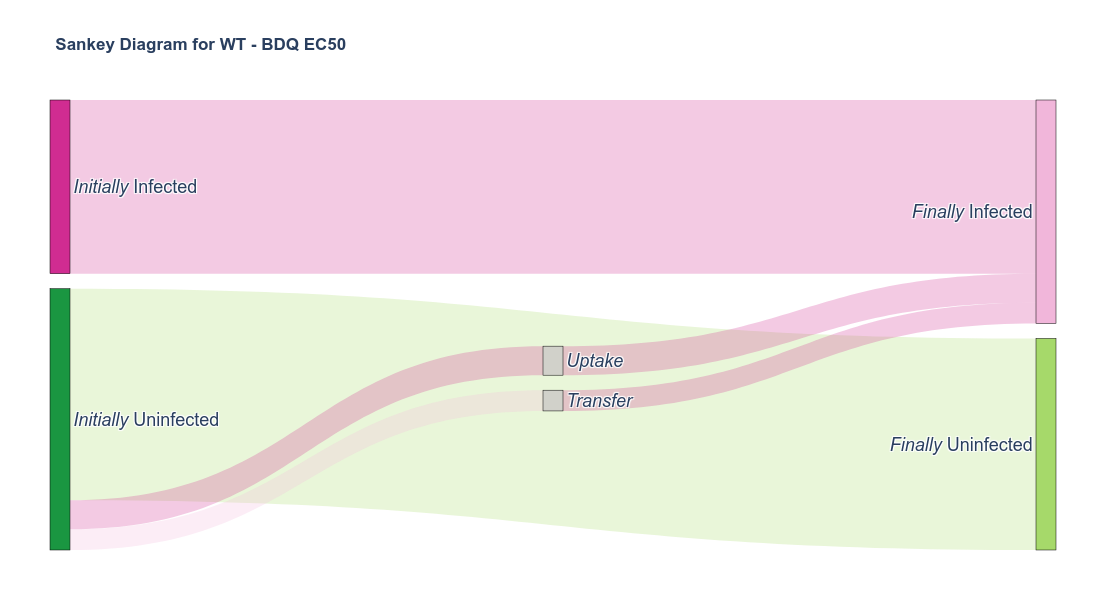

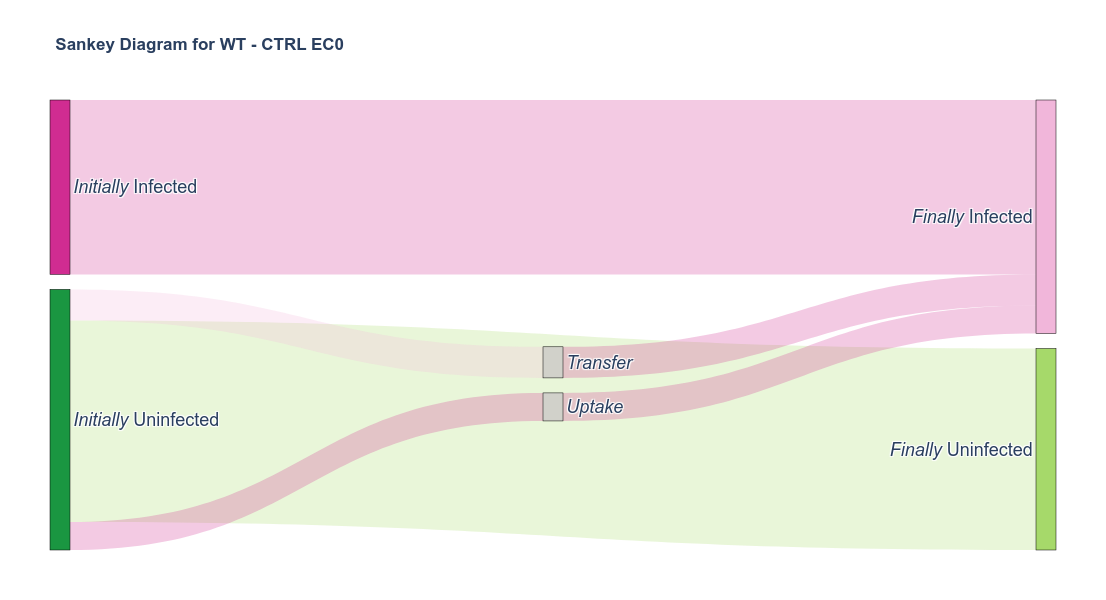

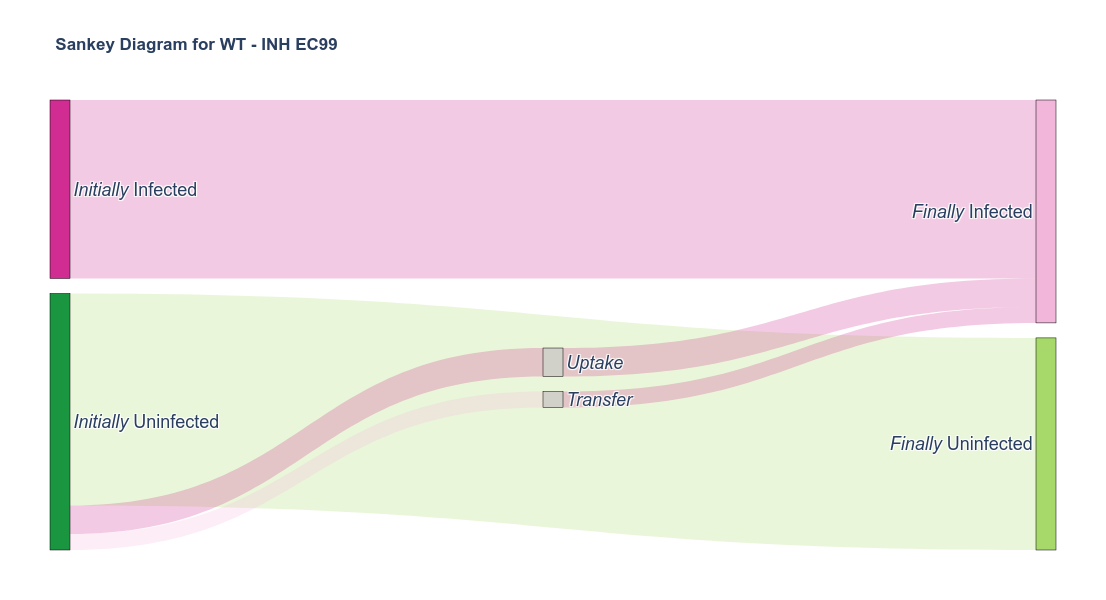

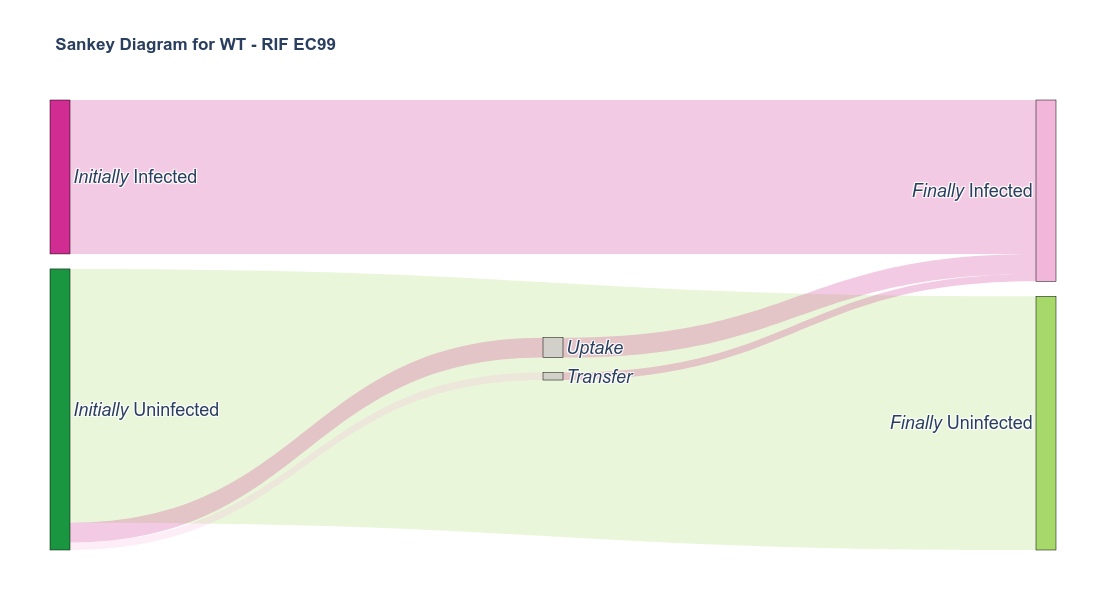

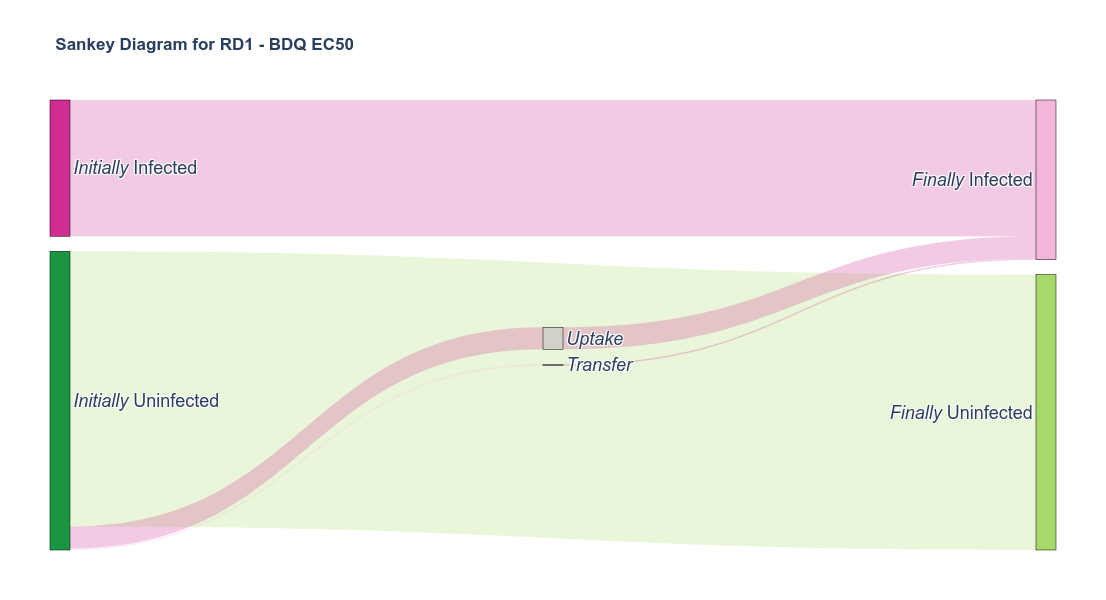

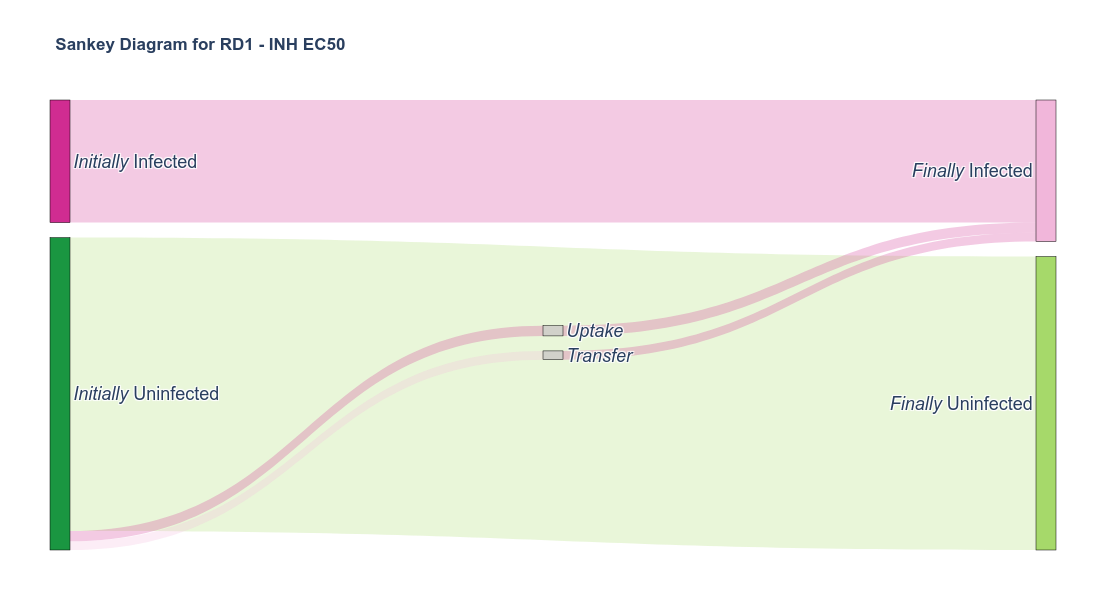

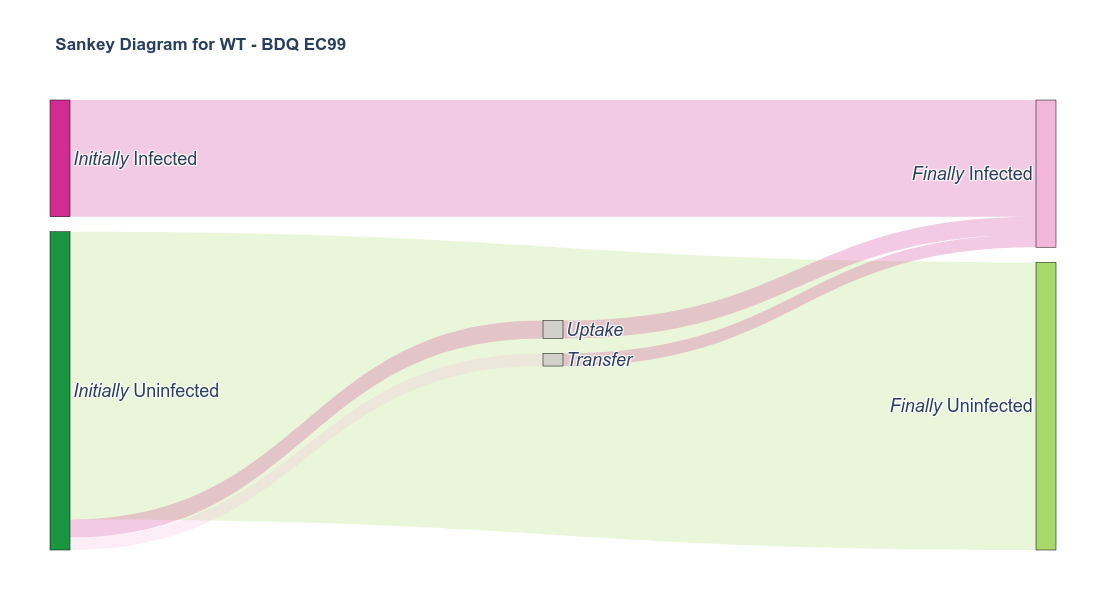

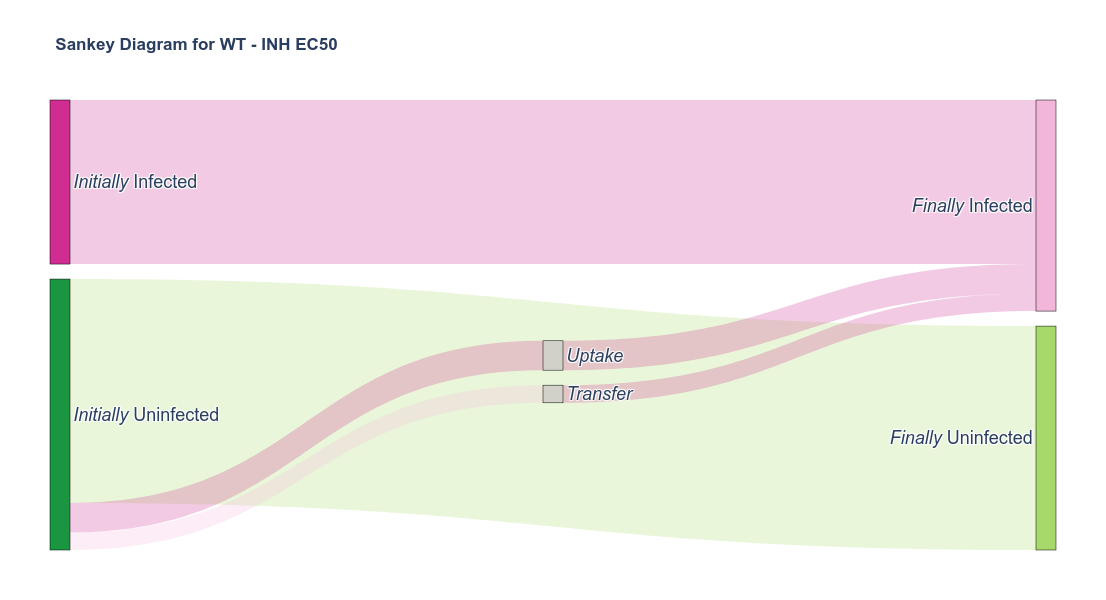

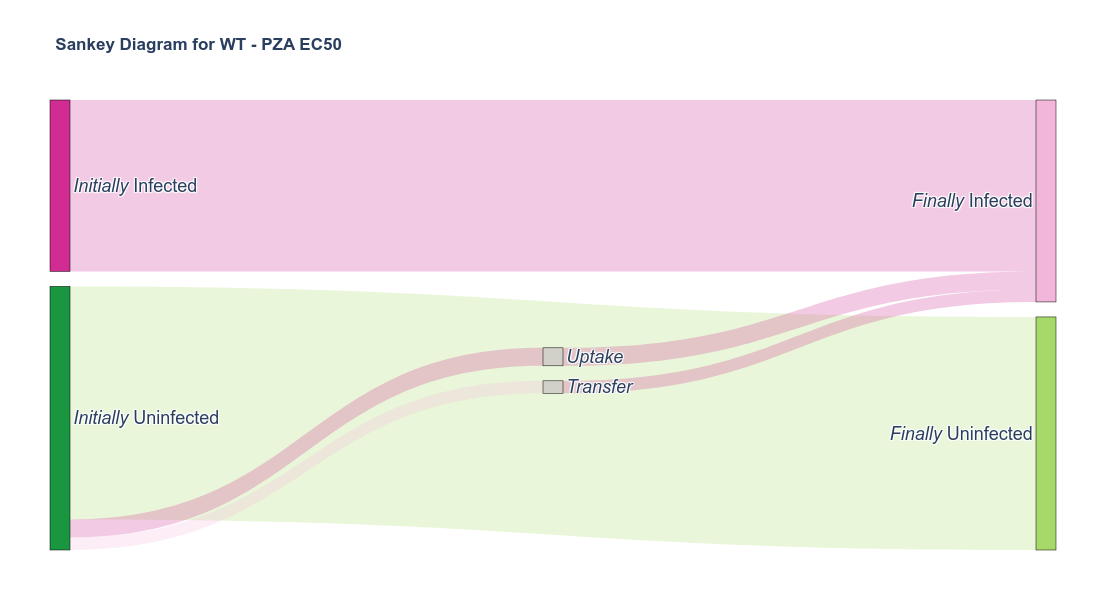

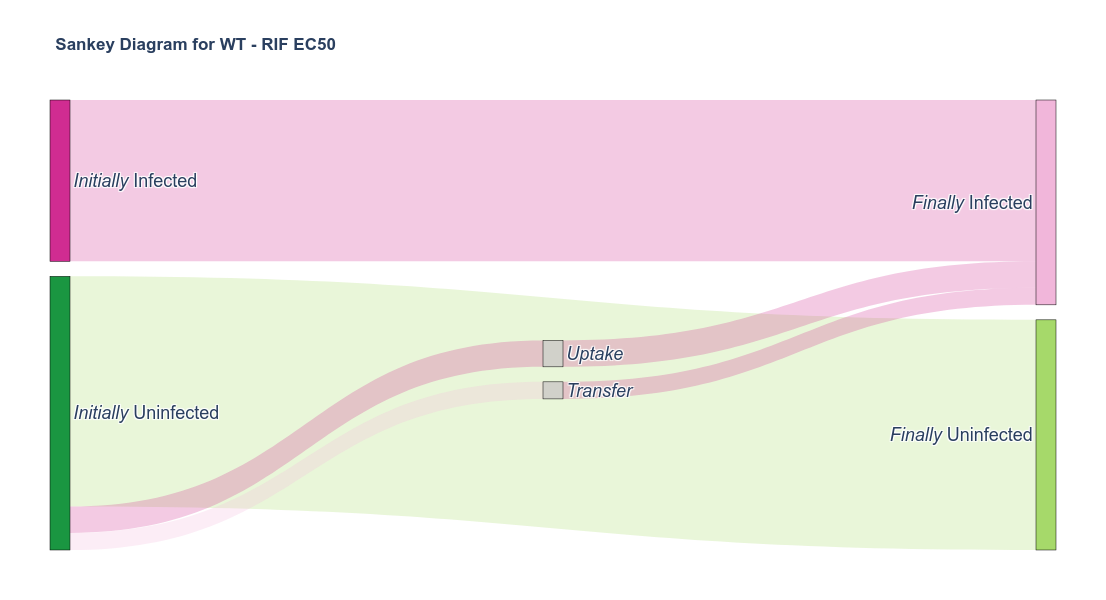

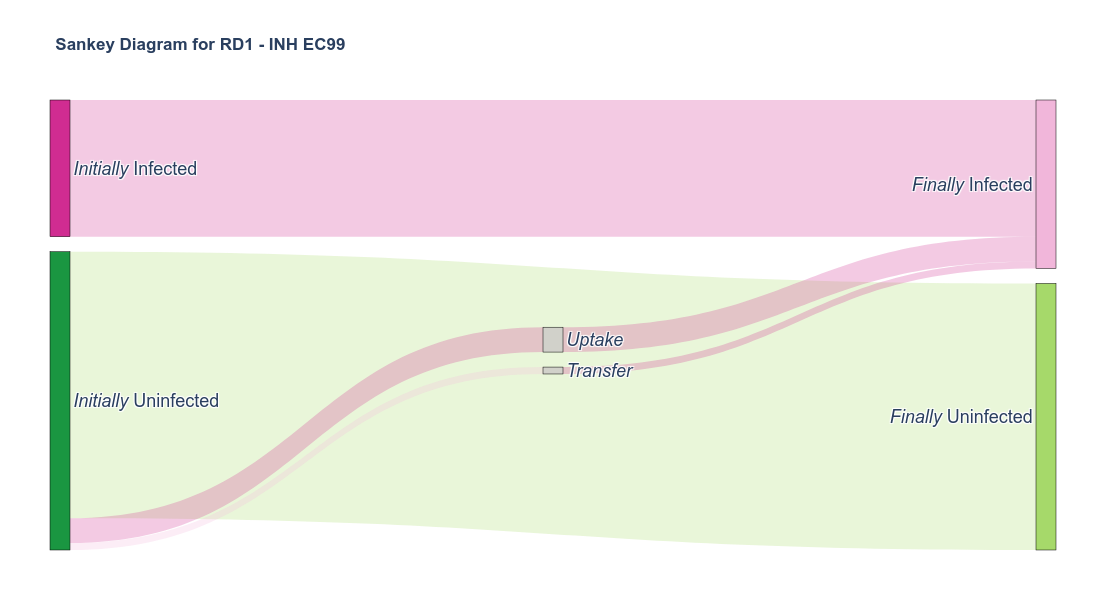

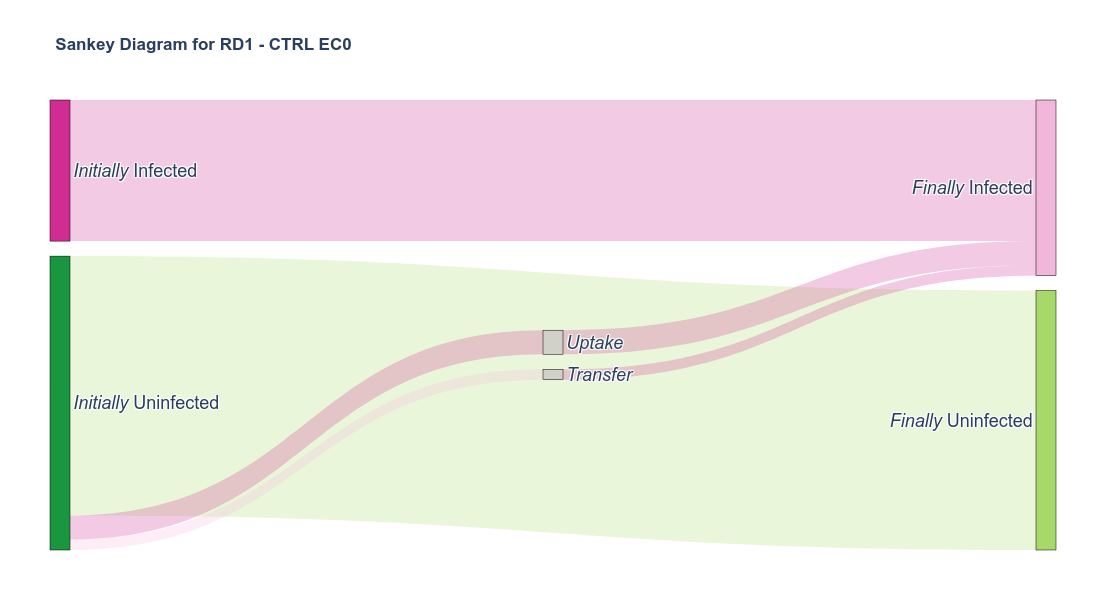

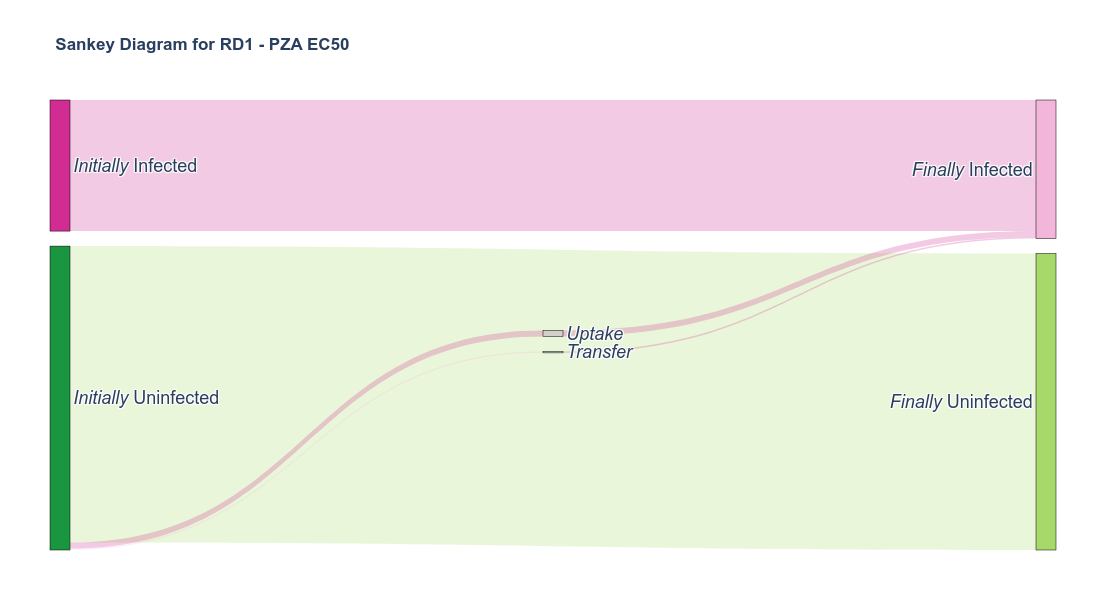

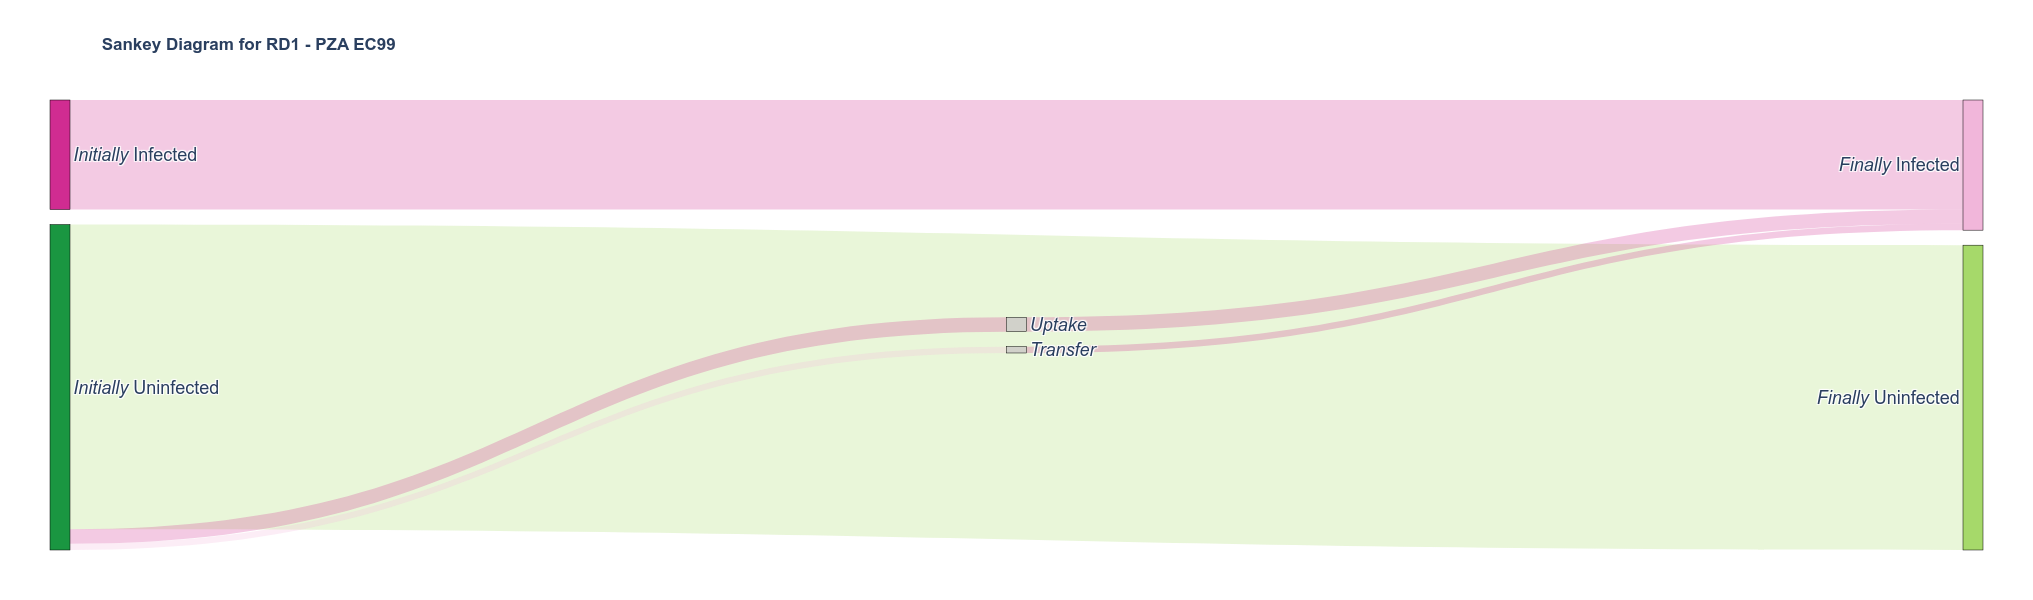

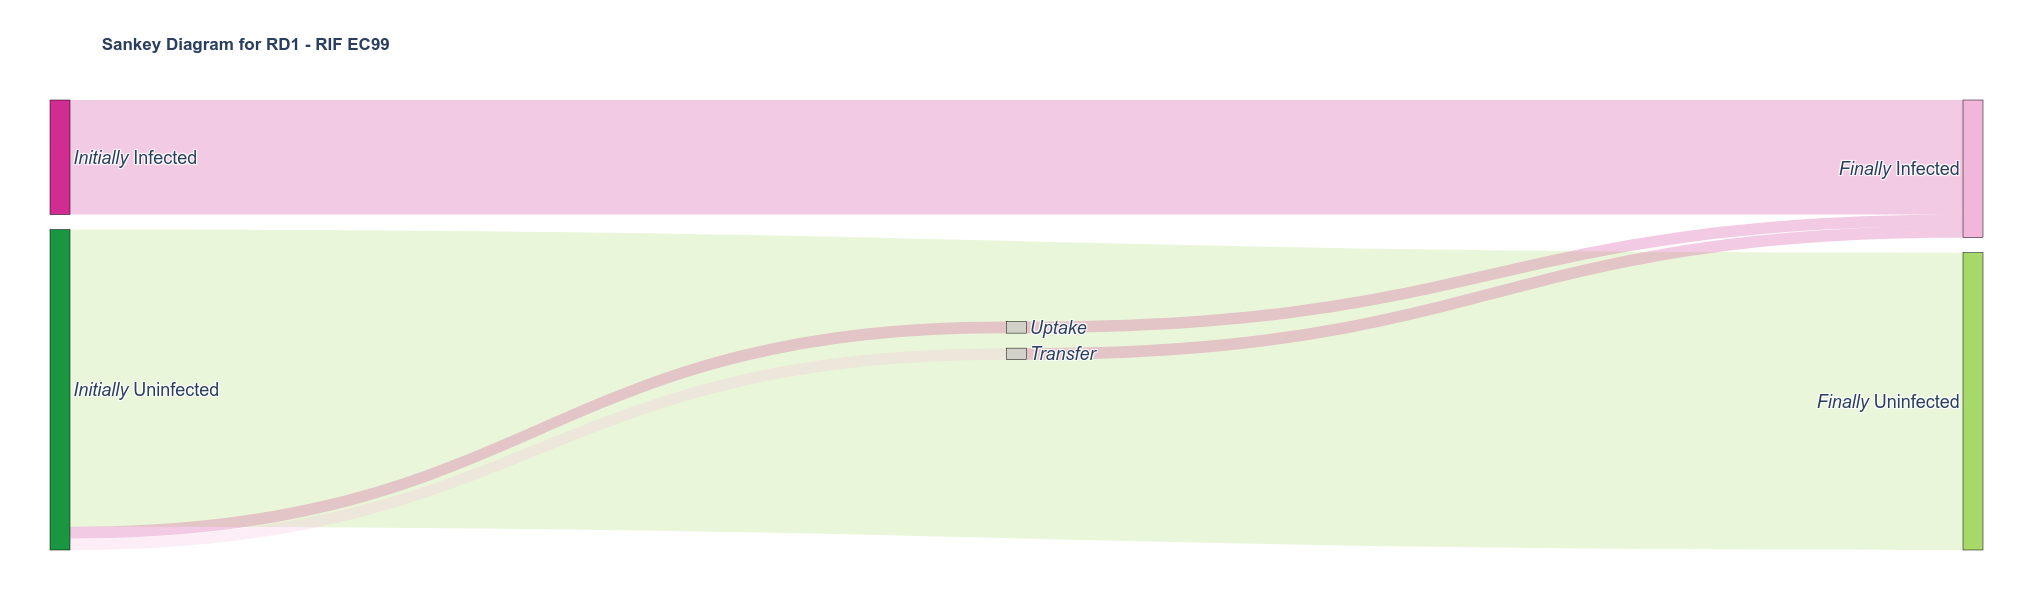

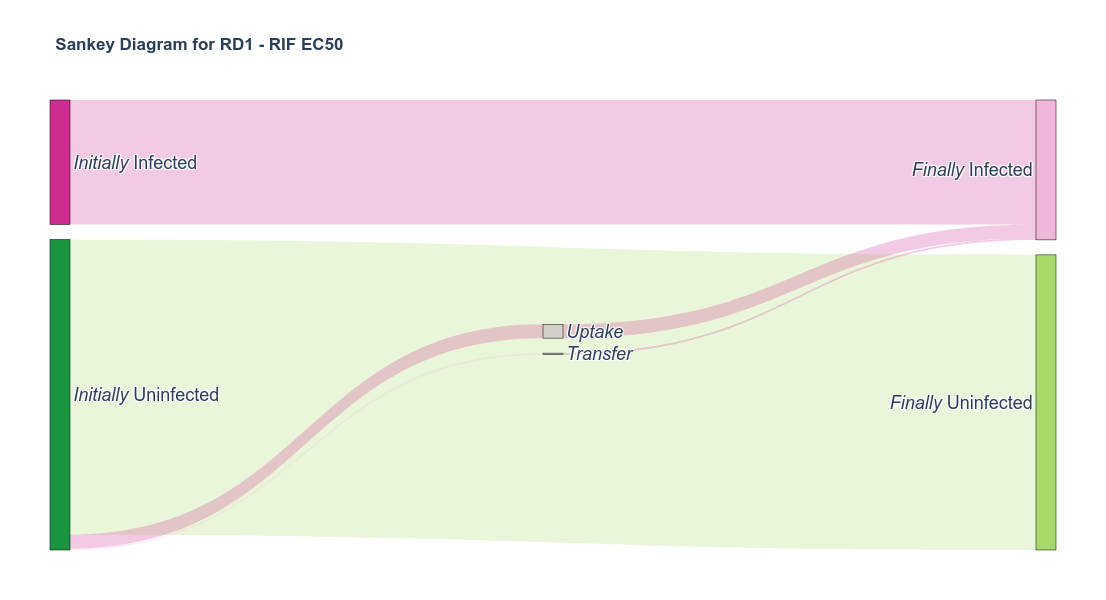

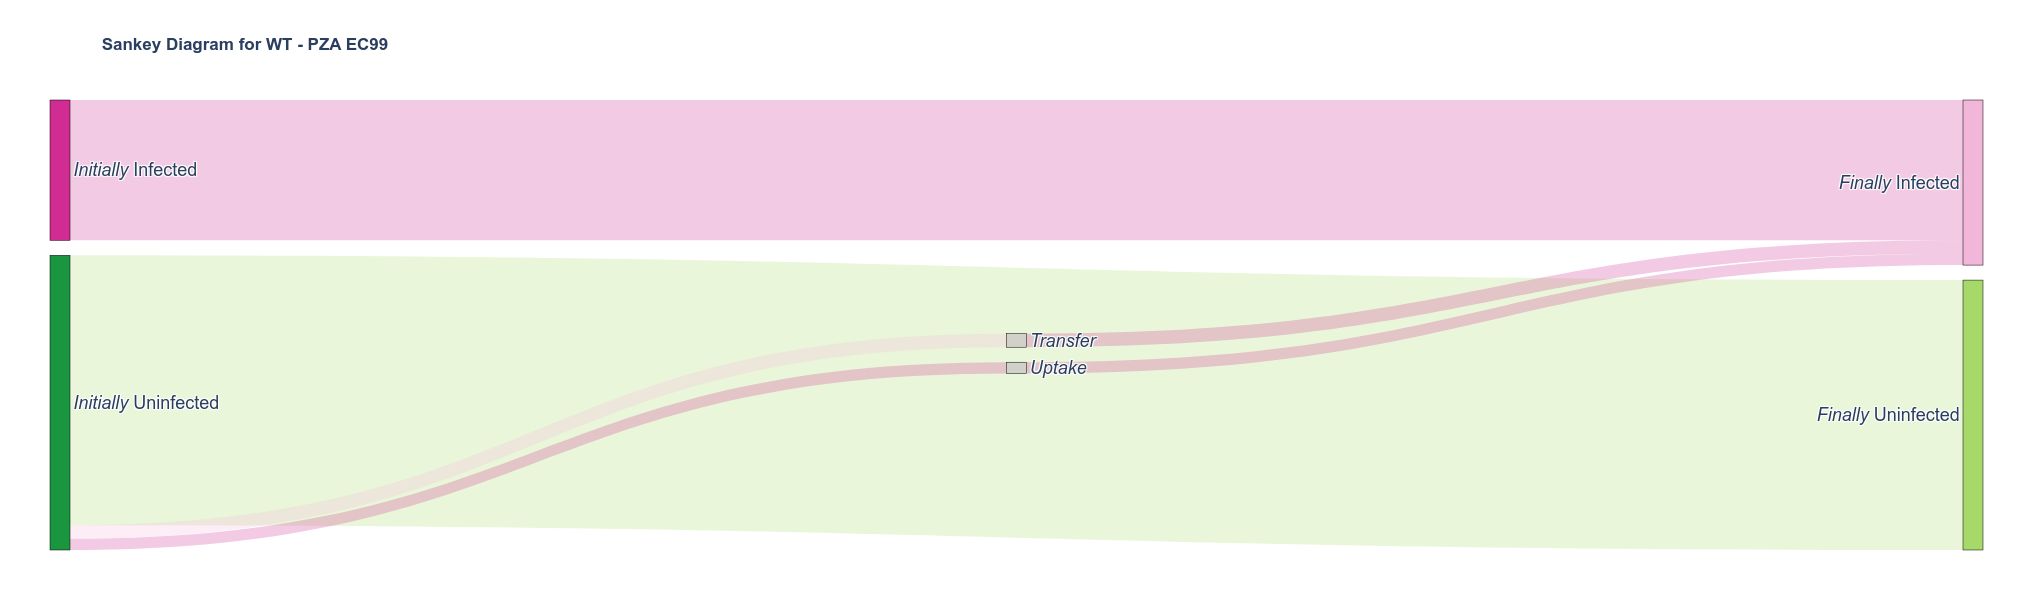

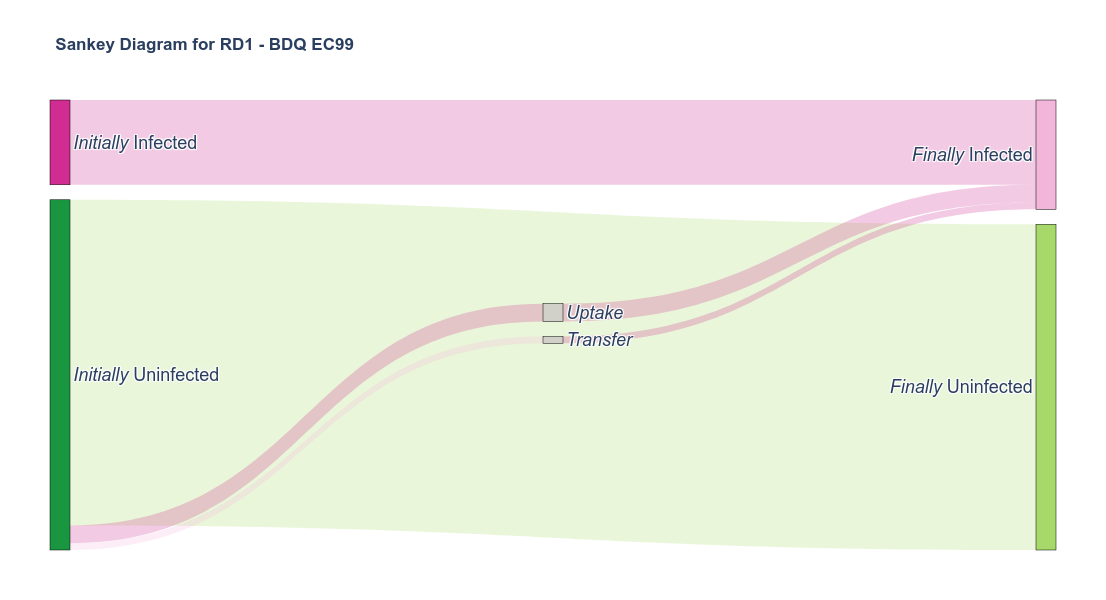

In [29]:
# Define labels and colors (unchanged)
labels = [
    "<i>Initially</i> Infected", "<i>Initially</i> Uninfected",
    "<i>Finally</i> Infected", "<i>Finally</i> Uninfected",
    "<i>Uptake</i>", "<i>Transfer</i>"
]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)'
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Loop through each sankey_data and create a separate Sankey diagram for each
for idx, data in enumerate(sankey_data_list):
    # Create a new figure for each Sankey diagram
    fig = go.Figure()

    # Normalize values
    normalization_factor = data['total'] / max_total
    N_stayed_infected = data['N_stayed_infected'] / normalization_factor
    N_got_uninfected = 0#data['N_got_uninfected'] / normalization_factor
    N_got_infected = 0#data['N_got_infected'] / normalization_factor
    N_stayed_uninfected = data['N_stayed_uninfected'] / normalization_factor
    N_uptake = data['N_uptake'] / normalization_factor
    N_transfer = data['N_transfer'] / normalization_factor
    
    # Create value list
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Ensure no negative or NaN values
    value = [max(v, 0) if not pd.isnull(v) else 0 for v in value]
    
    # Define source and target arrays
    source = [0, 0, 1, 1, 1, 1, 4, 5]
    target = [2, 3, 2, 3, 4, 5, 2, 2]
    
    # Create the Sankey diagram
    sankey = go.Sankey(
        domain=dict(x=[0, 1], y=[0, 1]),
        orientation='h',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        textfont=dict(size=18)
    )
    
    # Add the Sankey diagram to the figure
    fig.add_trace(sankey)
    
    # # Add annotation for the Sankey diagram
    # fig.add_annotation(
    #     x=0.5,
    #     y=1,
    #     text=f"{data['strain']} under {data['compound']} {data['concentration']}",
    #     showarrow=False,
    #     font=dict(size=32),
    #     xanchor='center',
    #     xref='paper',
    #     yref='paper'
    # )

    # Update layout for each figure
    fig.update_layout(
        title_text=f"<b>Sankey Diagram for {data['strain']} - {data['compound']} {data['concentration']}</b>",
        width=800,  # Adjust as needed
        height=600,  # Adjust as needed
        font_family="Helvetica",
        margin=dict(l=50, r=50, t=100, b=50),
    )

    # Save each figure with a unique filename
    # fig.write_image(f'{syno_base_dir()}/results/27sept/allsankey/sankey_diagram_{data["strain"]}_{data["compound"]}_{data["concentration"]}.pdf')
    
    # Display each figure
    fig.show()

# Adding all together in one big plot 

In [40]:
ctrl_rd1_data

[{'strain': 'RD1',
  'compound': 'CTRL',
  'concentration': 'EC0',
  'N_stayed_infected': 364,
  'N_got_uninfected': 71,
  'N_got_infected': 25,
  'N_stayed_uninfected': 669,
  'N_uptake': 62,
  'N_transfer': 27,
  'N_unknown': 5,
  'N_junk': 37,
  'total': 1218}]

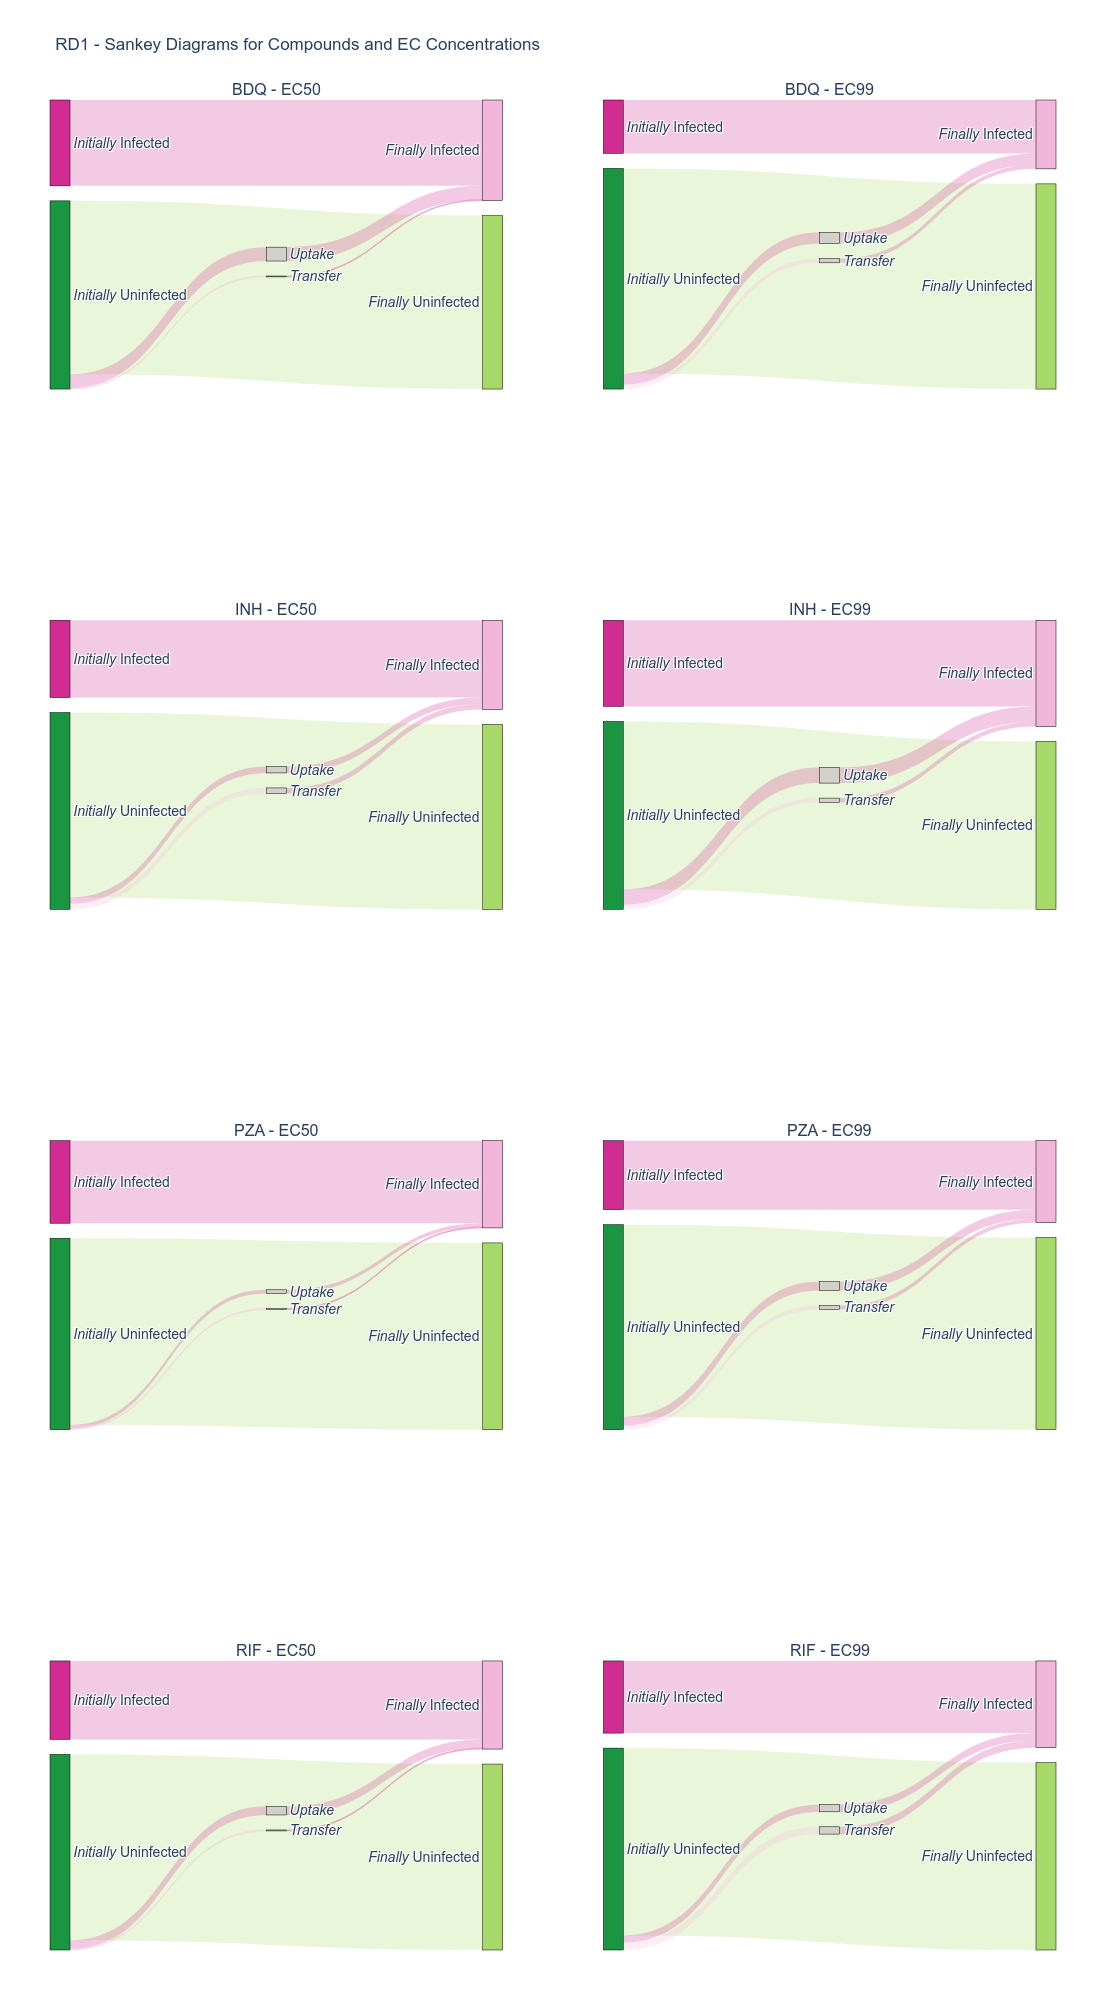

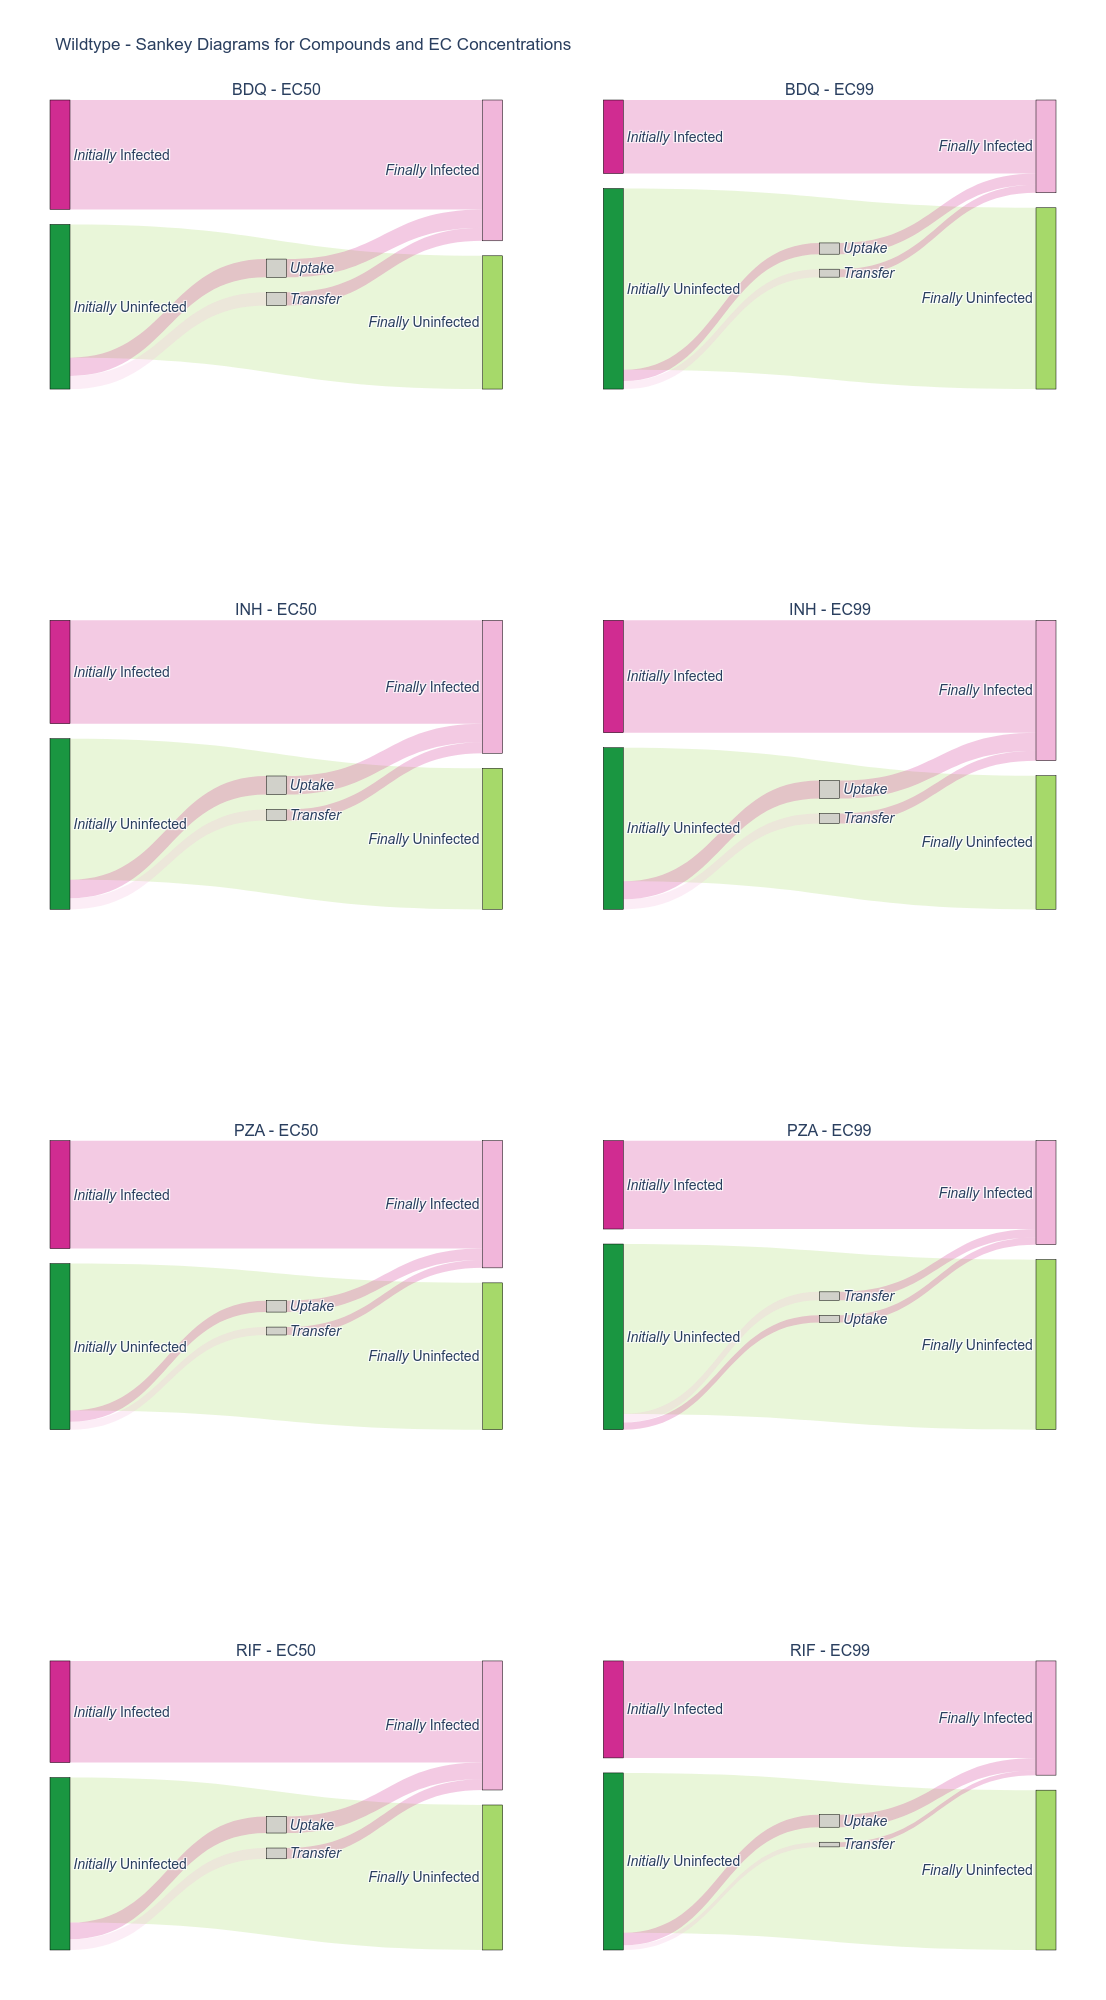

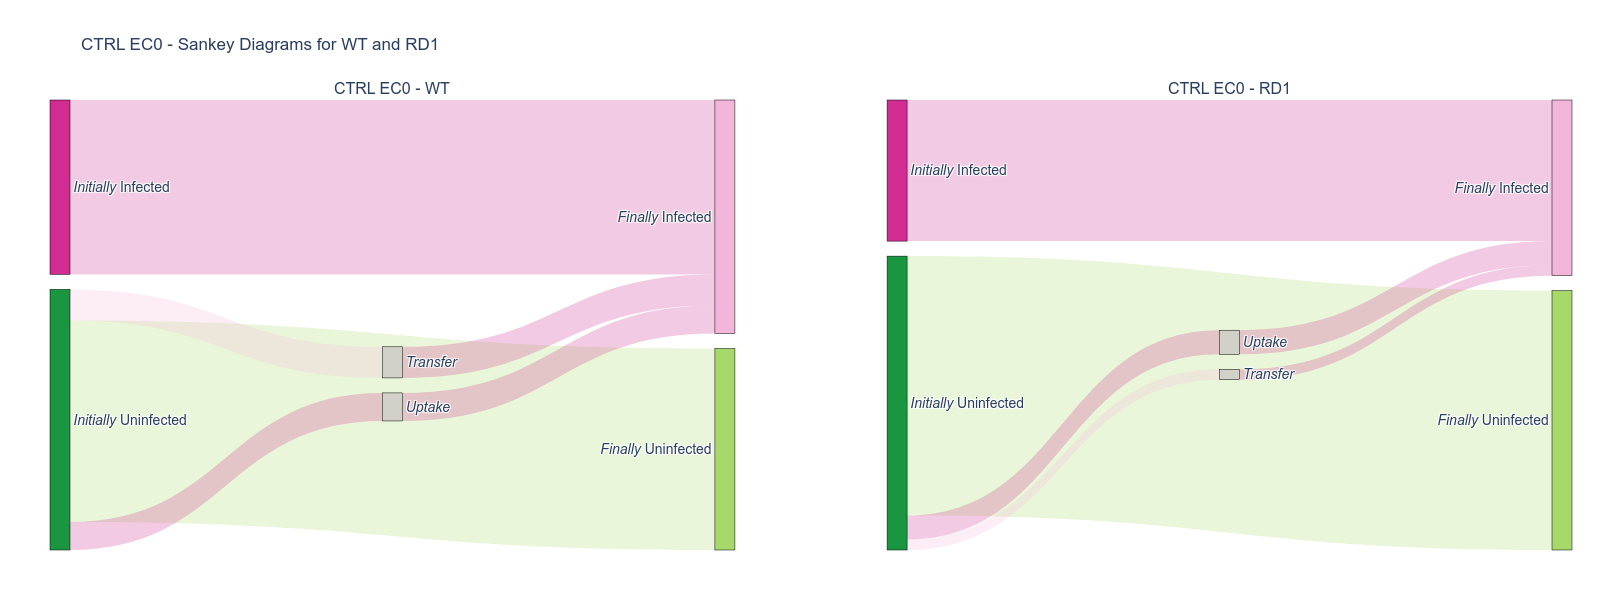

In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Separate RD1, Wildtype, and CTRL datasets
rd1_data = [data for data in sankey_data_list if data['strain'] == 'RD1' and data['compound'] != 'CTRL']
wt_data = [data for data in sankey_data_list if data['strain'] == 'WT' and data['compound'] != 'CTRL']
ctrl_wt_data = [data for data in sankey_data_list if data['compound'] == 'CTRL' and data['concentration'] == 'EC0' and data['strain'] == 'WT']
ctrl_rd1_data = [data for data in sankey_data_list if data['compound'] == 'CTRL' and data['concentration'] == 'EC0' and data['strain'] == 'RD1']

# Get unique compounds and EC concentrations for RD1 and Wildtype (excluding 'CTRL')
compounds_rd1 = sorted(set(data['compound'] for data in rd1_data))
compounds_wt = sorted(set(data['compound'] for data in wt_data))
ec_concentrations_rd1 = sorted(set(data['concentration'] for data in rd1_data))
ec_concentrations_wt = sorted(set(data['concentration'] for data in wt_data))

# Determine the number of rows and columns for the RD1 and Wildtype grids
n_rows_rd1 = len(compounds_rd1)
n_cols_rd1 = len(ec_concentrations_rd1)
n_rows_wt = len(compounds_wt)
n_cols_wt = len(ec_concentrations_wt)

# Create subplot grids for RD1 and Wildtype
fig_rd1 = make_subplots(rows=n_rows_rd1, cols=n_cols_rd1,
                        subplot_titles=[f"{compound} - {concentration}"
                                        for compound in compounds_rd1 for concentration in ec_concentrations_rd1],
                        specs=[[{'type': 'sankey'}]*n_cols_rd1 for _ in range(n_rows_rd1)])

fig_wt = make_subplots(rows=n_rows_wt, cols=n_cols_wt,
                       subplot_titles=[f"{compound} - {concentration}"
                                       for compound in compounds_wt for concentration in ec_concentrations_wt],
                       specs=[[{'type': 'sankey'}]*n_cols_wt for _ in range(n_rows_wt)])

# Function to add Sankey diagrams to a figure
def add_sankey_to_figure(fig, data, compounds, ec_concentrations, row_offset=0):
    for data_entry in data:
        # Determine the correct row and column for the subplot
        row = compounds.index(data_entry['compound']) + 1  # Plotly is 1-based indexing
        col = ec_concentrations.index(data_entry['concentration']) + 1
        
        # Normalize values (same process as before)
        normalization_factor = data_entry['total'] / max_total
        N_stayed_infected = data_entry['N_stayed_infected'] / normalization_factor
        N_got_uninfected = 0  # data_entry['N_got_uninfected'] / normalization_factor
        N_got_infected = 0  # data_entry['N_got_infected'] / normalization_factor
        N_stayed_uninfected = data_entry['N_stayed_uninfected'] / normalization_factor
        N_uptake = data_entry['N_uptake'] / normalization_factor
        N_transfer = data_entry['N_transfer'] / normalization_factor

        # Create value list for Sankey
        value = [
            N_stayed_infected, N_got_uninfected, N_got_infected, N_stayed_uninfected,
            N_uptake, N_transfer, N_uptake, N_transfer
        ]

        # Ensure no negative or NaN values
        value = [max(v, 0) if not pd.isnull(v) else 0 for v in value]

        # Define source and target arrays
        source = [0, 0, 1, 1, 1, 1, 4, 5]
        target = [2, 3, 2, 3, 4, 5, 2, 2]

        # Create the Sankey diagram
        sankey = go.Sankey(
            domain=dict(x=[0, 1], y=[0, 1]),
            orientation='h',
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=labels,
                color=node_colors,
            ),
            link=dict(
                source=source,
                target=target,
                value=value,
                color=link_colors
            ),
            textfont=dict(size=14)
        )

        # Add the Sankey diagram to the correct subplot in the grid
        fig.add_trace(sankey, row=row + row_offset, col=col)


# Now, plot the CTRL EC0 separately in its own row for both WT and RD1
fig_ctrl = make_subplots(rows=1, cols=2, specs=[[{'type': 'sankey'}, {'type': 'sankey'}]], subplot_titles=["CTRL EC0 - WT", "CTRL EC0 - RD1"])

# Add CTRL EC0 Sankey diagrams for WT in the first column (row=1, col=1)
add_sankey_to_figure(fig_ctrl, ctrl_wt_data, ['CTRL'], ['EC0'], row_offset=0)

# Manually specify that the second CTRL EC0 diagram goes into the second column (row=1, col=2)
for data_entry in ctrl_rd1_data:
    # Normalize values for RD1 CTRL EC0
    normalization_factor = data_entry['total'] / max_total
    N_stayed_infected = data_entry['N_stayed_infected'] / normalization_factor
    N_stayed_uninfected = data_entry['N_stayed_uninfected'] / normalization_factor
    N_uptake = data_entry['N_uptake'] / normalization_factor
    N_transfer = data_entry['N_transfer'] / normalization_factor
    
    # Create value list for Sankey
    value = [
        N_stayed_infected, 0, 0, N_stayed_uninfected,
        N_uptake, N_transfer, N_uptake, N_transfer
    ]
    value = [max(v, 0) if not pd.isnull(v) else 0 for v in value]

    source = [0, 0, 1, 1, 1, 1, 4, 5]
    target = [2, 3, 2, 3, 4, 5, 2, 2]

    sankey = go.Sankey(
        domain=dict(x=[0, 1], y=[0, 0.]),
        orientation='h',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        textfont=dict(size=14)
    )

    # Add the Sankey diagram to the second column
    fig_ctrl.add_trace(sankey, row=1, col=2)

# Add Sankey diagrams for RD1 and Wildtype to their respective grids
add_sankey_to_figure(fig_rd1, rd1_data, compounds_rd1, ec_concentrations_rd1)
add_sankey_to_figure(fig_wt, wt_data, compounds_wt, ec_concentrations_wt)


# Update layout for the RD1 and Wildtype grids
fig_rd1.update_layout(
    title_text="RD1 - Sankey Diagrams for Compounds and EC Concentrations",
    width=1200, height=2000,
    font_family="Helvetica",
    margin=dict(l=50, r=50, t=100, b=50),
)

fig_wt.update_layout(
    title_text="Wildtype - Sankey Diagrams for Compounds and EC Concentrations",
    width=1200, height=2000,
    font_family="Helvetica",
    margin=dict(l=50, r=50, t=100, b=50),
)

fig_ctrl.update_layout(
    title_text="CTRL EC0 - Sankey Diagrams for WT and RD1",
    width=1200, height=600,
    font_family="Helvetica",
    margin=dict(l=50, r=50, t=100, b=50),
)


# Show the plots
fig_rd1.show()
fig_wt.show()
fig_ctrl.show()
fig_rd1.write_image(f'{syno_base_dir()}/results/27sept/allsankey/sankey_diagram_rd1.pdf')
fig_wt.write_image(f'{syno_base_dir()}/results/27sept/allsankey/sankey_diagram_wt.pdf')
fig_ctrl.write_image(f'{syno_base_dir()}/results/27sept/allsankey/sankey_diagram_ctrl.pdf')

In [35]:
ec_concentrations_rd1

['EC50', 'EC99']

# arx

In [22]:
wt_mtb_df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
389,1.3.3.ND0003,0.0,0.0,0.000000,469.429446,202.767597,NaN,False,False,42.471859,...,True,False,NaN,NaN,NaN,NaN,None,None,None,1.0
390,1.3.3.ND0003,0.5,0.0,0.000000,528.854007,202.767597,NaN,False,False,34.811165,...,True,False,0.0,NaN,NaN,NaN,None,None,None,1.0
391,1.3.3.ND0003,1.0,0.0,0.000000,537.145286,202.767597,NaN,False,False,33.768791,...,True,False,0.0,NaN,NaN,NaN,None,None,None,1.0
392,1.3.3.ND0003,1.5,0.0,0.000000,701.920497,202.767597,NaN,False,False,38.236599,...,True,False,0.0,NaN,NaN,NaN,None,None,None,1.0
393,1.3.3.ND0003,2.0,0.0,0.000000,612.839527,202.767597,False,False,False,32.407787,...,True,False,0.0,NaN,0.0,0.0,None,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312045,996.4.5.PS0000,70.0,0.0,-3.888632,727.062500,-186.967234,False,True,False,642.705505,...,False,False,0.0,0.0,70.0,0.0,None,None,None,0.89
1312046,996.4.5.PS0000,71.0,0.0,-3.888632,701.808716,-186.967234,False,True,False,638.446594,...,False,False,0.0,0.0,71.0,0.0,None,None,None,0.89
1312047,996.4.5.PS0000,72.0,0.0,-3.888632,742.840515,-186.967234,False,True,False,639.983704,...,False,False,0.0,0.0,72.0,0.0,None,None,None,0.89
1312048,996.4.5.PS0000,73.0,0.0,-3.888632,948.580444,-186.967234,NaN,True,False,635.667175,...,False,False,0.0,0.0,NaN,NaN,None,None,None,0.89


In [29]:
from macrohet import visualise
colours = expanded_piyg = visualise.color_palette('expanded_piyg').colors


In [32]:
expanded_piyg

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']

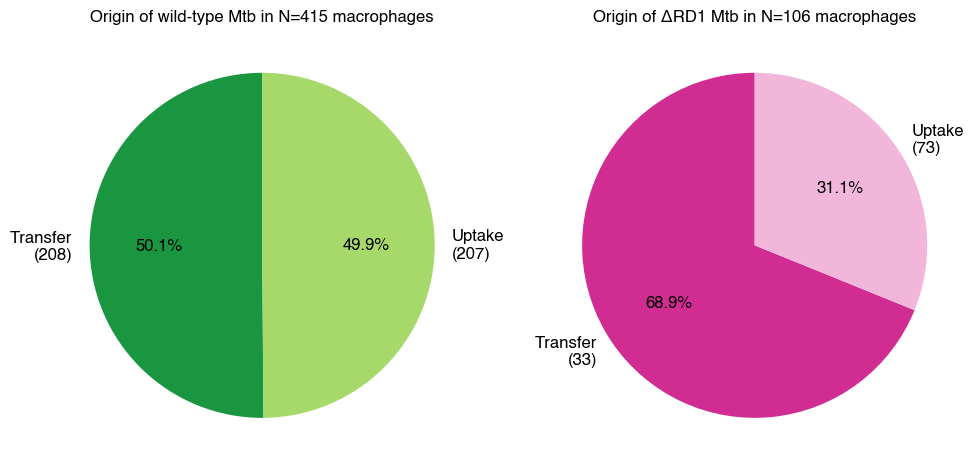

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for wild-type Mtb and ΔRD1 Mtb while excluding 'Unknown' and 'Junk' from 'mtb_origin'
wt_mtb_df = df[(df['Strain'] == 'WT')  & (df['Strain'] != 'UNI') & (df['Concentration'] == 'EC0') & 
               (~df['mtb_origin'].isin(['Unknown', 'Junk']))]
ard1_mtb_df = df[(df['Strain'] == 'RD1')  & (df['Strain'] != 'UNI') & (df['Concentration'] == 'EC0') & 
                 (~df['mtb_origin'].isin(['Unknown', 'Junk']))]
wt_mtb_df = wt_mtb_df.drop_duplicates('ID')
ard1_mtb_df = ard1_mtb_df.drop_duplicates('ID')

# Group by 'mtb_origin' and count occurrences
wt_mtb_data = wt_mtb_df['mtb_origin'].value_counts(normalize=True) * 100  # Normalize to get percentages
ard1_mtb_data = ard1_mtb_df['mtb_origin'].value_counts(normalize=True) * 100  # Normalize to get percentages

# Counts for labels
wt_mtb_counts = wt_mtb_df['mtb_origin'].value_counts()
ard1_mtb_counts = ard1_mtb_df['mtb_origin'].value_counts()

# Labels (adjust based on what is in df['mtb_origin'])
labels = wt_mtb_data.index.tolist()  # ['Uptake', 'Transfer', etc.] after dropping 'Unknown' and 'Junk'

# Color scheme (adjusted if needed)
colors = colours # Using 'expanded_piyg' colors, adjust as needed

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for wild-type Mtb
axes[0].pie(wt_mtb_data, labels=[f'{label}\n({wt_mtb_counts[label]})' for label in labels],
            autopct='%1.1f%%', startangle=90, colors=[colors[0],colors[1]], textprops={'fontsize': 12})
axes[0].set_title('Origin of wild-type Mtb in N=415 macrophages')#.format(wt_mtb_df.shape[0]), fontsize=14)

# Pie chart for ΔRD1 Mtb
axes[1].pie(ard1_mtb_data, labels=[f'{label}\n({ard1_mtb_counts[label]})' for label in labels],
            autopct='%1.1f%%', startangle=90, colors=[colors[-1],colors[-2]], textprops={'fontsize': 12})
axes[1].set_title('Origin of ΔRD1 Mtb in N=106 macrophages')#.format(ard1_mtb_df.shape[0]), fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f'{syno_base_dir()}/results/27sept/comparison_pie_charts_macrophage_origin.pdf', dpi=314, bbox_inches='tight')

# Show the figure
plt.show()

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Get all unique combinations of compound and concentration
conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

In [ ]:

for i, condition in tqdm(conditions.iterrows()):

    strain = condition[0]
    compound = condition[1]
    concentration = condition[2]
    
    subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
    subset_df.drop_duplicates('ID', inplace=True)
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]
    
    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]
    
    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors =  [colours.expanded_piyg[i] for i in [-1,0, -2, 1]] #['blue', 'green', 'red', 'yellow']  # Example node colors
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation = 'v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,        
            color=node_colors  # Set node colors
    
        ),
        link=dict(
            source=source,
            target=target,
            value=value, 
            color=link_colors
        ))])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        # font_size=12,
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x = 0.5, y =0.95)
    )
    
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.show()

## Ipywidgets interactive version

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

# Sample dataframe setup
# df should include columns: 'Strain', 'Compound', 'Concentration', 'Initial Infection Status', 'Final Infection Status', 'ID'
# conditions should be a list or dataframe containing all unique combinations of 'Strain', 'Compound', 'Concentration'

# Function to create the Sankey diagram for a selected condition
def create_sankey(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]

    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]  # Example node colors

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    fig.update_layout(
        title=dict(
            text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>",
            font=dict(size=20),
            x=0.5,
            y=0.95
        ),
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans",
        annotations=annotations
    )

    fig.show()

# Extract unique values for dropdown menus
strains = df['Strain'].unique()
compounds = df['Compound'].unique()
concentrations = df['Concentration'].unique()

# Create interactive widgets
interact(create_sankey,
         strain=Dropdown(options=strains, description='Strain:'),
         compound=Dropdown(options=compounds, description='Compound:'),
         concentration=Dropdown(options=concentrations, description='Concentration:')
        )


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Sample dataframe setup
# df should include columns: 'Strain', 'Compound', 'Concentration', 'Initial Infection Status', 'Final Infection Status', 'ID'

# Extract unique values for dropdown menus
strains = df['Strain'].unique()
compounds = df['Compound'].unique()
concentrations = df['Concentration'].unique()

# Create the Sankey diagram function
def create_sankey_trace(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1]  # 0: Initially Infected, 1: Initially Uninfected
    target = [2, 3, 2, 3]  # 2: Finally Infected, 3: Finally Uninfected
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected    # Initially Uninfected -> Finally Uninfected
    ]

    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]]

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]  # Example node colors

    # Create the Sankey trace
    trace = go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        visible=False  # Set initial visibility to False
    )
    return trace

conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates().values
# Create initial traces for all combinations
traces = []
buttons = []
for idx, (strain, compound, concentration) in enumerate(conditions):
    trace = create_sankey_trace(strain, compound, concentration)
    traces.append(trace)
    buttons.append(dict(
        label=f"{strain} {compound} {concentration}",
        method="update",
        args=[{
                "visible": [False] * len(traces)
            }, {
                "title": f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
                "annotations": [
                    dict(
                        x=0,
                        y=1.05,
                        text="Status at <b><i>initial frame</i></b> of track",
                        showarrow=False,
                        font=dict(size=14)
                    ),
                    dict(
                        x=0,
                        y=-0.05,
                        text="Status at <b><i>final frame</i></b> of track",
                        showarrow=False,
                        font=dict(size=14)
                    )
                ]
            }]
    ))
    # Set visibility of the current trace to True
    buttons[-1]['args'][0]['visible'][idx] = True
    
# Create the initial figure
fig = go.Figure(data=traces)

# Make the first trace visible initially
fig.data[0].visible = True

# Create the dropdown menu
updatemenu = [dict(buttons=buttons, direction="down", showactive=True)]

# Update the layout to include the dropdown menu
fig.update_layout(
    updatemenus=updatemenu,
    title="Select Condition",
    annotations=[
        dict(
            x=0,
            y=1.05,
            text="Status at <b><i>initial frame</i></b> of track",
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,
            y=-0.05,
            text="Status at <b><i>final frame</i></b> of track",
            showarrow=False,
            font=dict(size=14)
        )
    ],
    width=800,
    height=600,
    font_family="Liberation Sans"
)

# Save as HTML
fig.write_html('/mnt/SYNO/macrohet_syno/results/sankey/WIP_interactive_sankey.html')

# Show the figure in Jupyter notebook (optional)
fig.show()


In [ ]:
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_strain,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.9,
            'yanchor': 'top'
        },
        {
            'buttons': dropdown_compound,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.8,
            'yanchor': 'top'
        },
        {
            'buttons': dropdown_concentration,
            'direction': 'down',
            'showactive': True,
            'x': -0.15,
            'xanchor': 'left',
            'y': 0.7,
            'yanchor': 'top'
        }
    ]
)


# Attempting to incorporate time into these diagrams

In [ ]:
df['Duration (hours)'] = None

In [ ]:
duration_tuple

In [ ]:
len(df[df['ID'] == ID])

In [ ]:
[duration_tuple] * len(df[df['ID'] == ID])

In [ ]:

# Group by ID and calculate initial and final times
duration_df = df.groupby('ID')['Time (hours)'].agg(['first', 'last']).reset_index()
duration_df['Duration (hours)'] = list(zip(duration_df['first'], duration_df['last']))

# Drop the 'first' and 'last' columns as they are no longer needed
duration_df.drop(columns=['first', 'last'], inplace=True)

# Merge the duration data back to the original DataFrame
df = pd.merge(df, duration_df, on='ID')

In [ ]:
# Rename columns if there are any conflicts after merge
df.rename(columns={'Duration (hours)_y': 'Duration (hours)'}, inplace=True)


In [ ]:
subset_df = df[(df['Strain'] == strain)
               & (df['Compound'] == compound)
               & (df['Concentration'] == concentration)]
subset_df.drop_duplicates('ID', inplace=True)

# Extract initial and final time from the duration tuple
subset_df['Initial Time'] = subset_df['Duration (hours)'].apply(lambda x: x[0])
subset_df['Final Time'] = subset_df['Duration (hours)'].apply(lambda x: x[1])

# Normalize time to the range [0, 1]
max_time = subset_df['Final Time'].max()
subset_df['Initial Time Norm'] = subset_df['Initial Time'] / max_time
subset_df['Final Time Norm'] = subset_df['Final Time'] / max_time

transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status', 'Initial Time Norm', 'Final Time Norm'])['ID'].apply(list).reset_index()

In [ ]:

# Create the data for the Sankey diagram
source = []
target = []
value = []
link_colors = []

for _, row in transitions.iterrows():
    initial_status = row['Initial Infection Status']
    final_status = row['Final Infection Status']
    ids = row['ID']

    for id in ids:
        source.append(node_positions['Initially Infected'] if initial_status == 1 else node_positions['Initially Uninfected'])
        target.append(node_positions['Finally Infected'] if final_status == 1 else node_positions['Finally Uninfected'])
        value.append(1)  # Each individual line represents one transition
        link_colors.append(f'rgba({int(colours.expanded_piyg[-1][1:3], 16)}, {int(colours.expanded_piyg[-1][3:5], 16)}, {int(colours.expanded_piyg[-1][5:7], 16)}, 0.01)')

# Define labels for nodes
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]

# Create nodes with fixed positions
nodes = [
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[0], color=node_colors[0], x=0, y=0.5),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[1], color=node_colors[1], x=0, y=0),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[2], color=node_colors[2], x=1, y=0.5),
    dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[3], color=node_colors[3], x=1, y=0)
]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[node['label'] for node in nodes],
        color=[node['color'] for node in nodes],
        x=[node['x'] for node in nodes],
        y=[node['y'] for node in nodes]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=1,  # x position of right label
        y=1.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.show()


In [ ]:
# Fix the position of nodes
node_positions = {
    'Initially Infected': 0,
    'Initially Uninfected': 1,
    'Finally Infected': 2,
    'Finally Uninfected': 3
}

# Create the Sankey diagram function
def create_sankey_with_duration(strain, compound, concentration):
    subset_df = df[(df['Strain'] == strain)
                   & (df['Compound'] == compound)
                   & (df['Concentration'] == concentration)]
    subset_df.drop_duplicates('ID', inplace=True)

    # Extract initial and final time from the duration tuple
    subset_df['Initial Time'] = subset_df['Duration (hours)'].apply(lambda x: x[0])
    subset_df['Final Time'] = subset_df['Duration (hours)'].apply(lambda x: x[1])

    # Normalize time to the range [0, 1]
    max_time = subset_df['Final Time'].max()
    subset_df['Initial Time Norm'] = subset_df['Initial Time'] / max_time
    subset_df['Final Time Norm'] = subset_df['Final Time'] / max_time

    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status', 'Initial Time Norm', 'Final Time Norm'])['ID'].apply(list).reset_index()

    # Create the data for the Sankey diagram
    source = []
    target = []
    value = []
    link_colors = []

    for _, row in transitions.iterrows():
        initial_status = row['Initial Infection Status']
        final_status = row['Final Infection Status']
        ids = row['ID']

        for id in ids:
            source.append(node_positions['Initially Infected'] if initial_status == 1 else node_positions['Initially Uninfected'])
            target.append(node_positions['Finally Infected'] if final_status == 1 else node_positions['Finally Uninfected'])
            value.append(1)  # Each individual line represents one transition
            link_colors.append(f'rgba({int(colours.expanded_piyg[-1][1:3], 16)}, {int(colours.expanded_piyg[-1][3:5], 16)}, {int(colours.expanded_piyg[-1][5:7], 16)}, 0.01)')

    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1]]

    # Create nodes with fixed positions
    nodes = [
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[0], color=node_colors[0], x=0, y=0.5),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[1], color=node_colors[1], x=0, y=0),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[2], color=node_colors[2], x=1, y=0.5),
        dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels[3], color=node_colors[3], x=1, y=0)
    ]

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node['label'] for node in nodes],
            color=[node['color'] for node in nodes],
            x=[node['x'] for node in nodes],
            y=[node['y'] for node in nodes]
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=1,  # x position of right label
            y=1.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]

    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )

    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.show()

# Example usage
create_sankey_with_duration('WT', 'CTRL', 'EC0')

In [ ]:
manual_label_df['dt']

In [ ]:
strain = 'WT' #condition[0]
compound = condition[1]
concentration = condition[2]

# Load manual labels
manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain.lower()}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
    
manual_label_df = pd.read_csv(manual_label_fn)

subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                       & (manual_label_df['Compound'] == compound)
                                       & (manual_label_df['Concentration'] == concentration)
                                      ]

subset_df = df[(df['Strain'] == strain)
             & (df['Compound'] == compound)
             & (df['Concentration'] == concentration)
             ]
subset_df.drop_duplicates('ID', inplace=True)

# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

# Count the intermediate transitions
N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
# Remove these manual observations from the original N_got_infected count
N_got_infected = N_got_infected - (N_uptake + N_transfer)

# Define source, target, and value for Sankey diagram
source = [0, 0, 1, 1, 1, 1, 4, 5, 0]  # Added sources for uptake and transfer
target = [2, 3, 2, 3, 4, 5, 2, 2, 2]  # Added targets for uptake and transfer
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,   # Transfer -> Finally Infected
    1,
]

# Assuming colours.expanded_piyg is a list of hex colors
link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]]

# Define labels for nodes
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]

# # Set fixed positions for nodes
# node_x = [0, 0.1, 0.9, 0.9, 0.3, 0.5]
# node_y = [1, 0.2, 0.8, 0.2, 0.6, 0.4]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
        # x=node_x,
        # y=node_y
    ),
    link=dict(
        
        source=source,
        target=target,
        value=value,
        color=link_colors, 
        
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    # font_size=12,
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)
fig.show()

# Interactive 

In [ ]:
min_dt = 0
max_dt = 100

# Load manual labels
manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain.lower()}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
manual_label_df = pd.read_csv(manual_label_fn)

# Load subset of the dataframe (assuming df is predefined)
subset_df = df[(df['Strain'] == strain)
             & (df['Compound'] == compound)
             & (df['Concentration'] == concentration)]
subset_df.drop_duplicates('ID', inplace=True)

# Filter numeric 'dt' values and remove NaNs
subset_df = subset_df[subset_df['dt'] > min_time] 
numeric_dt_values = subset_df['dt'].dropna().unique()
numeric_dt_values = [dt for dt in numeric_dt_values if pd.api.types.is_numeric_dtype(type(dt))]

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.RangeSlider(
        id='dt-slider',
        min=min(numeric_dt_values),
        max=max(numeric_dt_values),
        value=[min(numeric_dt_values), max(numeric_dt_values)],
        marks={int(dt): str(int(dt)) for dt in numeric_dt_values},
        step=2
    ),
    dcc.Graph(id='sankey-graph')
])

# Modify the callback function to handle the range of values
@app.callback(
    Output('sankey-graph', 'figure'),
    Input('dt-slider', 'value')
)
def update_sankey(selected_dt_range):
    min_dt, max_dt = selected_dt_range

    subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                           & (manual_label_df['Compound'] == compound)
                                           & (manual_label_df['Concentration'] == concentration)
                                           & (manual_label_df['dt'] >= min_dt)
                                           & (manual_label_df['dt'] <= max_dt)]

    subset_df_filtered = subset_df[(subset_df['dt'] >= min_dt) & (subset_df['dt'] <= max_dt)]

    transitions = subset_df_filtered.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
    N_got_infected = N_got_infected - (N_uptake + N_transfer)

    source = [0, 0, 1, 1, 1, 1, 4, 5, ]
    target = [2, 3, 2, 3, 4, 5, 2, 2, ]
    value = [
        N_stayed_infected, N_got_uninfected, N_got_infected, N_stayed_uninfected,
        N_uptake, N_transfer, N_uptake, N_transfer, 
    ]

    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = ['#d02c91', '#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da']
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in node_colors]

    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    annotations = [
        dict(x=0, y=1.05, text="Status at <b><i>initial frame</i></b> of track", showarrow=False, font=dict(size=14)),
        dict(x=0, y=-0.05, text="Status at <b><i>final frame</i></b> of track", showarrow=False, font=dict(size=14))
    ]

    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800, height=600, font_family="Liberation Sans",
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", font=dict(size=20), x=0.5, y=0.95)
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
len(value)

# if the track doesnt exist at the final frame of the movie, then is that cell dead? 

add labels that show beginning of movie / end of movie 

incorporate actual fate from the manual identification

# Incorporate manual labels in 

In [ ]:
conditions

In [ ]:
subset_df

# Using individual manual label files

In [ ]:
# Get all unique combinations of strain, compound, and concentration
conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

for i, condition in tqdm(conditions.iterrows()):

    strain = condition[0]
    compound = condition[1]
    concentration = condition[2]

    # Load manual labels
    manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
    
    if not os.path.exists(manual_label_fn):
        print(f'No manual labels for {strain, compound, concentration}')
        continue
        
    manual_label_df = pd.read_csv(manual_label_fn)
    
    subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
                                           & (manual_label_df['Compound'] == compound)
                                           & (manual_label_df['Concentration'] == concentration)
                                          ]
    
    subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    # Count the intermediate transitions
    N_uptake = subset_manual_label_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = subset_manual_label_df['mtb_origin'].value_counts().get('Transfer', 0)
    # Remove these manual observations from the original N_got_infected count
    N_got_infected = N_got_infected - (N_uptake + N_transfer)
    
    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1, 1, 1, 4, 5]  # Added sources for uptake and transfer
    target = [2, 3, 2, 3, 4, 5, 2, 2]  # Added targets for uptake and transfer
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]]
    
    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
    
    # # Set fixed positions for nodes
    # node_x = [0, 0.1, 0.9, 0.9, 0.3, 0.5]
    # node_y = [1, 0.2, 0.8, 0.2, 0.6, 0.4]
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,  # Set node colors
            # x=node_x,
            # y=node_y
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ))])
    
    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]
    
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        # font_size=12,
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
    fig.show()

# taking manual info from new df

In [ ]:
condition

In [ ]:
# Get all unique combinations of strain, compound, and concentration
conditions = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

for i, condition in tqdm(conditions.iterrows()):
    
    strain = condition[0]
    if strain == 'UNI':
        continue
    compound = condition[1]
    concentration = condition[2]

    

    # # Load manual labels
    # manual_label_fn = f'/mnt/SYNO/macrohet_syno/results/mtb_origin/{strain}_{compound}_{concentration}_init_uninf_updated_rapid_growers.csv'
    
    # if not os.path.exists(manual_label_fn):
    #     print(f'No manual labels for {strain, compound, concentration}')
    #     continue
        
    # manual_label_df = pd.read_csv(manual_label_fn)
    
    # subset_manual_label_df = manual_label_df[(manual_label_df['Strain'] == strain)
    #                                        & (manual_label_df['Compound'] == compound)
    #                                        & (manual_label_df['Concentration'] == concentration)
    #                                       ]
    
    subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    
    # Count the intermediate transitions
    N_uptake = subset_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = subset_df['mtb_origin'].value_counts().get('Transfer', 0)
    # Remove these manual observations from the original N_got_infected count
    N_got_infected = N_got_infected - (N_uptake + N_transfer)
    
    # Define source, target, and value for Sankey diagram
    source = [0, 0, 1, 1, 1, 1, 4, 5]  # Added sources for uptake and transfer
    target = [2, 3, 2, 3, 4, 5, 2, 2]  # Added targets for uptake and transfer
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Assuming colours.expanded_piyg is a list of hex colors
    link_colors = [f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]]
    
    # Define labels for nodes
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
    
    # # Set fixed positions for nodes
    # node_x = [0, 0.1, 0.9, 0.9, 0.3, 0.5]
    # node_y = [1, 0.2, 0.8, 0.2, 0.6, 0.4]
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,  # Set node colors
            # x=node_x,
            # y=node_y
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ))])
    
    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]
    
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        # font_size=12,
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
    fig.show()


In [ ]:
df.keys()

# working now with the refined df

that has a better initial infection status definition (3 hours) and neater organising

In [ ]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df.pkl')

In [ ]:
strain = 'WT'
compound = 'CTRL'
concentration = 'EC0'

subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
subset_df.drop_duplicates('ID', inplace=True)



# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])

# Count the intermediate transitions
N_uptake = subset_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = subset_df['mtb_origin'].value_counts().get('Transfer', 0)
# Count the intermediate transitions for 'Unknown' and 'Junk'
# Count the intermediate transitions for 'Unknown' and 'Junk'
N_unknown = subset_df['mtb_origin'].value_counts().get('Unknown', 0)
N_junk = subset_df['mtb_origin'].value_counts().get('Junk', 0)

# Update the transition values
N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)

# Update the source, target, and value arrays to include the new categories
source = [0, 0, 1, 1, 1, 1, 4, 5, 1, 1, 6, 7]  # Added sources for uptake, transfer, unknown, and junk
target = [2, 3, 2, 3, 4, 5, 2, 2, 6, 7, 2, 2]  # Added targets for uptake, transfer, unknown, and junk
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,            # Transfer -> Finally Infected
    N_unknown,             # Unknown -> Finally Infected
    N_junk,                # Junk -> Finally Infected
    N_unknown,             # Unknown -> Finally Infected
    N_junk,                # Junk -> Finally Infected
]

# Assuming colours.expanded_piyg is a list of hex colors
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1, 2, 4]]
]

# Define labels for nodes, including 'Unknown' and 'Junk'
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>", "<i>Unknown</i>", "<i>Junk</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3, 2, 4]]

# Create the Sankey diagram with the updated source, target, value, labels, and node_colors
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

# Save and show the Sankey diagram
fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
fig.show()

# NEW APPROACH

In [ ]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_alt.pkl')

In [ ]:
strain = 'WT'
compound = 'CTRL'
concentration = 'EC0'

subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
subset_df.drop_duplicates('ID', inplace=True)



# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
print(N_got_infected)
# Count the intermediate transitions
# Get the IDs of cells that transitioned from uninfected to infected
infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]

# Filter subset_df to include only rows with IDs from N_got_infected
infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]

# Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)

# Update the transition values
N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)

print(N_got_infected)
# Update the source, target, and value arrays to include the new categories
source = [0, 0, 1, 1, 1, 1, 4, 5, 1, 1, 6, 7]  # Added sources for uptake, transfer, unknown, and junk
target = [2, 3, 2, 3, 4, 5, 2, 2, 6, 7, 2, 2]  # Added targets for uptake, transfer, unknown, and junk
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,            # Transfer -> Finally Infected
    N_unknown,             # Unknown -> Finally Infected
    N_junk,                # Junk -> Finally Infected
    N_unknown,             # Unknown -> Finally Infected
    N_junk,                # Junk -> Finally Infected
]

# Assuming colours.expanded_piyg is a list of hex colors
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1, 2, 4]]
]

# Define labels for nodes, including 'Unknown' and 'Junk'
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>", "<i>Unknown</i>", "<i>Junk</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3, 2, 4]]

# Create the Sankey diagram with the updated source, target, value, labels, and node_colors
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

# Save and show the Sankey diagram
fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
fig.show()

In [ ]:
len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])


In [ ]:
(N_uptake + N_transfer + N_unknown + N_junk)

In [ ]:
(N_uptake,  N_transfer,  N_unknown,  N_junk)

# manually adding more classifications in

In [ ]:
infected_IDs = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]


In [ ]:
uncertain_origin_IDs = [ID for ID in infected_IDs if pd.isna(subset_df[subset_df['ID'] == ID]['mtb_origin'].iloc[0])]

In [ ]:
uncertain_origin_IDs

In [ ]:
print(len(uncertain_origin_IDs))

In [ ]:
origin_df.to_csv(f'{output_dir}/origin_df_backup.csv', index=False)

In [ ]:
import pandas as pd
import os
import glob
import imageio
import napari
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image

glimpse_dir = r'/mnt/SYNO/macrohet_syno/glimpses/'
graph_dir = r'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v2/'

# where to put the output
output_dir = r'/mnt/SYNO/macrohet_syno/results/mtb_origin/'

# # Initialize the origin_df DataFrame
# origin_df = pd.DataFrame(columns=['ID', 'Origin', 'Start Hour', 'Stop Hour'])


for N, ID in tqdm(enumerate(uncertain_origin_IDs), total=len(uncertain_origin_IDs)):

    # Placeholder variables for start and stop hours
    start_hour = None
    stop_hour = None

    # # use enumeration to skip already processed
    # if N < 24:
    #     continue

    mp4_files = glob.glob(os.path.join(glimpse_dir, f'{ID}.mp4'))
    graph_files = glob.glob(os.path.join(graph_dir, f'*cell_ID.{ID}*.png'))
    
    if mp4_files:
        mp4_fn = mp4_files[0]
        if not graph_files:
            # graph_fn = graph_files[0]
            # get sc trajectory in df format
            sc_df = df[df['ID'] == ID]
            # Plot the experimental data and the fitted model
            plt.figure(figsize=(8, 6))
            # plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
            # plt.scatter(sc_dt_df['Time Model (hours)']-5/2, sc_dt_df['Mtb Area Processed (µm)'], label='Processed Data', color=pink_colors[2])
            plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label=f'Lowess Growth Model', color=colours.expanded_piyg[-2])
            plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours.expanded_piyg[0], s = 5)
            
            # Add labels, legend, and title
            plt.xlabel('Time (hours)')
            plt.ylabel('Mtb Area µm$^{2}$')
            plt.legend()
            cell_ID = sc_df['Unique ID'].unique()
            plt.title(f'Cell ID {ID} Intracellular Mtb Plot', weight='bold', fontsize = 16, pad=20) 
            sns.despine(offset = 10)
            # Show the plot
            plt.grid(False)

            graph_fn = os.path.join(graph_dir, f'temp_cell_ID.{ID}.png')

            plt.savefig(graph_fn, bbox_inches = 'tight', dpi = 314)
            
            # Load the mp4 and png files
            video = imageio.get_reader(mp4_fn, 'ffmpeg')
            img = imageio.imread(graph_fn)
            
            # Display in napari
            viewer = napari.Viewer()
            
            # Load video frames into a numpy array
            video_frames = np.array([frame for frame in video])
            
            # Resize the image to have the same height as the video
            video_height = video_frames.shape[1]
            img_resized = np.array(Image.fromarray(img).resize((int(img.shape[1] * (video_height / img.shape[0])), video_height)))
            
            # Add video and image to napari viewer
            viewer.add_image(video_frames, name=f'{ID} Video', blending='additive')
            viewer.add_image(img_resized, name=f'{ID} Image')
            viewer.grid.enabled = True
            viewer.dims.current_step = (0, 374, 374)
            
            # Define key binding functions
            def mark_transfer(viewer):
                # Update the origin_df DataFrame
                origin_df.loc[len(origin_df)] = [ID, 'Transfer', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Transfer' and added to origin_df.")
                origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

            def mark_uptake(viewer):
                # Update the origin_df DataFrame
                origin_df.loc[len(origin_df)] = [ID, 'Uptake', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Uptake' and added to origin_df.")
                origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

            def mark_junk(viewer):
                # Update the origin_df DataFrame
                origin_df.loc[len(origin_df)] = [ID, 'Junk', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Junk' and added to origin_df.")
                origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

            def mark_start(viewer):
                global start_hour
                current_frame = viewer.dims.current_step[0]
                start_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
                print(f"Start hour for ID {ID} marked at {start_hour} hours.")

            def mark_stop(viewer):
                global stop_hour
                current_frame = viewer.dims.current_step[0]
                stop_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
                print(f"Stop hour for ID {ID} marked at {stop_hour} hours.")
            
            # Add key bindings
            viewer.bind_key('t', mark_transfer)
            viewer.bind_key('u', mark_uptake)
            viewer.bind_key('j', mark_junk)
            viewer.bind_key('>', mark_start)
            viewer.bind_key('<', mark_stop)
            viewer.show(block=True)


In [ ]:
origin_df

In [ ]:
origin_df[origin_df['Start Hour'] > 0 ]

In [ ]:
origin_df[origin_df['ID']==ID][['mtb_origin', 'Start Hour', 'Stop Hour']].iloc[0]

In [ ]:
for ID in origin_df['ID'].unique():
    # Get the relevant row from origin_df
    origin_info = origin_df[origin_df['ID'] == ID][['mtb_origin', 'Start Hour', 'Stop Hour']].iloc[0]

    # Update the corresponding rows in df for the given ID
    # Update mtb_origin only if it's NaN in df
    df.loc[(df['ID'] == ID) & df['mtb_origin'].isna(), 'mtb_origin'] = origin_info['mtb_origin']

    # Update Start Hour and Stop Hour in df with the values from origin_df
    df.loc[df['ID'] == ID, 'Start Hour'] = origin_info['Start Hour']
    df.loc[df['ID'] == ID, 'Stop Hour'] = origin_info['Stop Hour']


In [ ]:
origin_df

In [ ]:
df

In [ ]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_alt.pkl')

In [ ]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_alt.pkl')

In [ ]:
strain = 'WT'
compound = 'CTRL'
concentration = 'EC0'

subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
subset_df.drop_duplicates('ID', inplace=True)

# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
print(N_got_infected)
# Count the intermediate transitions
# Get the IDs of cells that transitioned from uninfected to infected
infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]

# Filter subset_df to include only rows with IDs from N_got_infected
infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]

# Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)

# Update the transition values
N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)

# Update the source, target, and value arrays, removing 'Unknown' and 'Junk'
source = [0, 0, 1, 1, 1, 1, 4, 5]  # Removed sources for unknown and junk
target = [2, 3, 2, 3, 4, 5, 2, 2]  # Removed targets for unknown and junk
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,            # Transfer -> Finally Infected
]

# Update the link colors, removing the ones associated with 'Unknown' and 'Junk'
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Define labels for nodes, excluding 'Unknown' and 'Junk'
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]

# Create the Sankey diagram with the updated source, target, value, labels, and node_colors
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

# Update layout and save the figure
fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

# Save and show the Sankey diagram
fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
fig.show()

# check the initially infected to uninfected

In [ ]:
transitions.iloc[2]['ID']

In [ ]:
import pandas as pd
import os
import glob
import imageio
import napari
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image

glimpse_dir = r'/mnt/SYNO/macrohet_syno/glimpses/'
graph_dir = r'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v2/'

# where to put the output
output_dir = r'/mnt/SYNO/macrohet_syno/results/mtb_origin/'

# # Initialize the origin_df DataFrame
inf_uninf_origin_df = pd.DataFrame(columns=['ID', 'Origin', 'Start Hour', 'Stop Hour'])


for N, ID in tqdm(enumerate(transitions.iloc[2]['ID']), total=len(transitions.iloc[2]['ID'])):

    # Placeholder variables for start and stop hours
    start_hour = None
    stop_hour = None

    # # use enumeration to skip already processed
    # if N < 24:
    #     continue

    mp4_files = glob.glob(os.path.join(glimpse_dir, f'{ID}.mp4'))
    graph_files = glob.glob(os.path.join(graph_dir, f'*cell_ID.{ID}*.png'))
    
    if mp4_files:
        mp4_fn = mp4_files[0]
        if not graph_files:
            # graph_fn = graph_files[0]
            # get sc trajectory in df format
            sc_df = df[df['ID'] == ID]
            # Plot the experimental data and the fitted model
            plt.figure(figsize=(8, 6))
            # plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
            # plt.scatter(sc_dt_df['Time Model (hours)']-5/2, sc_dt_df['Mtb Area Processed (µm)'], label='Processed Data', color=pink_colors[2])
            plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label=f'Lowess Growth Model', color=colours.expanded_piyg[-2])
            plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours.expanded_piyg[0], s = 5)
            
            # Add labels, legend, and title
            plt.xlabel('Time (hours)')
            plt.ylabel('Mtb Area µm$^{2}$')
            plt.legend()
            cell_ID = sc_df['Unique ID'].unique()
            plt.title(f'Cell ID {ID} Intracellular Mtb Plot', weight='bold', fontsize = 16, pad=20) 
            sns.despine(offset = 10)
            # Show the plot
            plt.grid(False)

            graph_fn = os.path.join(graph_dir, f'temp_cell_ID.{ID}.png')

            plt.savefig(graph_fn, bbox_inches = 'tight', dpi = 314)
            
            # Load the mp4 and png files
            video = imageio.get_reader(mp4_fn, 'ffmpeg')
            img = imageio.imread(graph_fn)
            
            # Display in napari
            viewer = napari.Viewer()
            
            # Load video frames into a numpy array
            video_frames = np.array([frame for frame in video])
            
            # Resize the image to have the same height as the video
            video_height = video_frames.shape[1]
            img_resized = np.array(Image.fromarray(img).resize((int(img.shape[1] * (video_height / img.shape[0])), video_height)))
            
            # Add video and image to napari viewer
            viewer.add_image(video_frames, name=f'{ID} Video', blending='additive')
            viewer.add_image(img_resized, name=f'{ID} Image')
            viewer.grid.enabled = True
            viewer.dims.current_step = (0, 374, 374)
            
            # Define key binding functions
            def mark_transfer(viewer):
                # Update the origin_df DataFrame
                inf_uninf_origin_df.loc[len(inf_uninf_origin_df)] = [ID, 'Transfer', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Transfer' and added to origin_df.")
                inf_uninf_origin_df.to_csv(f'{output_dir}/inf_uninf_origin_df.csv', index=False)

            def mark_uptake(viewer):
                # Update the origin_df DataFrame
                inf_uninf_origin_df.loc[len(inf_uninf_origin_df)] = [ID, 'Uptake', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Uptake' and added to origin_df.")
                inf_uninf_origin_df.to_csv(f'{output_dir}/inf_uninf_origin_df.csv', index=False)

            def mark_junk(viewer):
                # Update the origin_df DataFrame
                inf_uninf_origin_df.loc[len(inf_uninf_origin_df)] = [ID, 'Junk', start_hour, stop_hour]
                print(f"ID {ID} marked as 'Junk' and added to origin_df.")
                inf_uninf_origin_df.to_csv(f'{output_dir}/inf_uninf_origin_df.csv', index=False)

            def mark_start(viewer):
                global start_hour
                current_frame = viewer.dims.current_step[0]
                start_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
                print(f"Start hour for ID {ID} marked at {start_hour} hours.")

            def mark_stop(viewer):
                global stop_hour
                current_frame = viewer.dims.current_step[0]
                stop_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
                print(f"Stop hour for ID {ID} marked at {stop_hour} hours.")
            
            # Add key bindings
            viewer.bind_key('t', mark_transfer)
            viewer.bind_key('u', mark_uptake)
            viewer.bind_key('j', mark_junk)
            viewer.bind_key('>', mark_start)
            viewer.bind_key('<', mark_stop)
            viewer.show(block=True)

### It has become clear that I ought to base the initial infection status on the growth model

# REPLOTTING WITH INIT AND FIN SATSTUS BASED OFF GROWTH MODEL

In [ ]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_alt.pkl')

In [ ]:
df

In [ ]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/mtb_origin/sc_df.pkl')

In [ ]:
N_got_infected

In [ ]:
strain = 'RD1'
compound = 'CTRL'
concentration = 'EC0'

subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 & (df['Edge Status'] == False)
                 & (df['mtb_origin'] != 'Junk')]
subset_df.drop_duplicates('ID', inplace=True)

# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
print(N_got_infected)
# Count the intermediate transitions
# Get the IDs of cells that transitioned from uninfected to infected
infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]

# Filter subset_df to include only rows with IDs from N_got_infected
infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]

# Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)

# Update the transition values
N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk) 

# Update the source, target, and value arrays, removing 'Unknown' and 'Junk'
source = [0, 0, 1, 1, 1, 1, 4, 5]  # Removed sources for unknown and junk
target = [2, 3, 2, 3, 4, 5, 2, 2]  # Removed targets for unknown and junk
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,            # Transfer -> Finally Infected
]

# Update the link colors, removing the ones associated with 'Unknown' and 'Junk'
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Define labels for nodes, excluding 'Unknown' and 'Junk'
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]

# Create the Sankey diagram with the updated source, target, value, labels, and node_colors
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

# Update layout and save the figure
fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=600,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

# Save and show the Sankey diagram
fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
fig.show()

In [ ]:
# Count the occurrences of each unique value in the 'mtb_origin' column excluding 'Junk'
mtb_origin_counts = subset_df[subset_df['mtb_origin'] != 'Junk']['mtb_origin'].value_counts()

# Colors from expanded_piyg
colors = ['#1a9641', '#a6d96a', '#f1b6da', '#d02c91']

# Calculate the total number
total = mtb_origin_counts.sum()

# Function to add counts to pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

# Plot the pie chart
plt.figure(figsize=(5,5))
mtb_origin_counts.plot.pie(
    autopct=lambda pct: func(pct, mtb_origin_counts), 
    startangle=90, 
    counterclock=False, 
    colors=colors
)

# Set title with total number
title = f'Origin of ΔRD1 Mtb in initially uninfected \nmacrophages (N={total})'
plt.title(title, )
plt.ylabel('')  # Hide the y-label

# Save the figure with filename based on the title
output_fn = title.replace(' ', '_') + '.pdf'
output_path = os.path.join(output_dir, 'graphs', output_fn)
plt.savefig(output_path, bbox_inches='tight', dpi=314)

# Display the pie chart
plt.show()

In [ ]:
output_path

In [ ]:
print('Init, Final')
[print(i['Initial Infection Status'],i['Final Infection Status'], len(i['ID'])) for j, i in transitions.iterrows()]

In [ ]:
transitions

In [ ]:
import pandas as pd
import os
import glob
import imageio
import napari
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image

glimpse_dir = r'/mnt/SYNO/macrohet_syno/glimpses/'
graph_dir = r'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v2/'

# where to put the output
output_dir = r'/mnt/SYNO/macrohet_syno/results/mtb_origin/'

# # Initialize the origin_df DataFrame
# inf_uninf_origin_df = pd.DataFrame(columns=['ID', 'Origin', 'Start Hour', 'Stop Hour'])

for N, ID in tqdm(enumerate(transitions.iloc[1]['ID']), total=len(transitions.iloc[1]['ID'])):

    # Placeholder variables for start and stop hours
    start_hour = None
    stop_hour = None

    # # use enumeration to skip already processed
    # if N < 24:
    #     continue
    if ID in origin_df['ID'].values:
        print('Already manually checked this ID', ID)

    if df[df['ID']==ID]['mtb_origin'] == 

    mp4_files = glob.glob(os.path.join(glimpse_dir, f'{ID}.mp4'))
    graph_files = glob.glob(os.path.join(graph_dir, f'*cell_ID.{ID}*.png'))
    
    if mp4_files:
        mp4_fn = mp4_files[0]

        # graph_fn = graph_files[0]
        # get sc trajectory in df format
        sc_df = df[df['ID'] == ID]
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(8, 6))
        # plt.scatter(sc_dt_df['Time (hours)'].values, raw_data, label='Raw Experimental Data', color=green_colors[-1])
        # plt.scatter(sc_dt_df['Time Model (hours)']-5/2, sc_dt_df['Mtb Area Processed (µm)'], label='Processed Data', color=pink_colors[2])
        plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label=f'Lowess Growth Model', color=colours.expanded_piyg[-2])
        plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours.expanded_piyg[0], s = 5)
        
        # Add labels, legend, and title
        plt.xlabel('Time (hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        cell_ID = sc_df['Unique ID'].unique()
        plt.title(f'Cell ID {ID} Intracellular Mtb Plot', weight='bold', fontsize = 16, pad=20) 
        sns.despine(offset = 10)
        # Show the plot
        plt.grid(False)

        graph_fn = os.path.join(graph_dir, f'temp_cell_ID.{ID}.png')

        plt.savefig(graph_fn, bbox_inches = 'tight', dpi = 314)
        plt.clf()
        # Load the mp4 and png files
        video = imageio.get_reader(mp4_fn, 'ffmpeg')
        img = imageio.imread(graph_fn)
        
        # Display in napari
        viewer = napari.Viewer()
        
        # Load video frames into a numpy array
        video_frames = np.array([frame for frame in video])
        
        # Resize the image to have the same height as the video
        video_height = video_frames.shape[1]
        img_resized = np.array(Image.fromarray(img).resize((int(img.shape[1] * (video_height / img.shape[0])), video_height)))
        
        # Add video and image to napari viewer
        viewer.add_image(video_frames, name=f'{ID} Video', blending='additive')
        viewer.add_image(img_resized, name=f'{ID} Image')
        viewer.grid.enabled = True
        viewer.dims.current_step = (0, 374, 374)
        
        # Define key binding functions
        def mark_transfer(viewer):
            # Update the origin_df DataFrame
            origin_df.loc[len(origin_df)] = [ID, 'Transfer', start_hour, stop_hour]
            print(f"ID {ID} marked as 'Transfer' and added to origin_df.")
            origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

        def mark_uptake(viewer):
            # Update the origin_df DataFrame
            origin_df.loc[len(origin_df)] = [ID, 'Uptake', start_hour, stop_hour]
            print(f"ID {ID} marked as 'Uptake' and added to origin_df.")
            origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

        def mark_junk(viewer):
            # Update the origin_df DataFrame
            origin_df.loc[len(origin_df)] = [ID, 'Junk', start_hour, stop_hour]
            print(f"ID {ID} marked as 'Junk' and added to origin_df.")
            origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

        def mark_start(viewer):
            global start_hour
            current_frame = viewer.dims.current_step[0]
            start_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
            print(f"Start hour for ID {ID} marked at {start_hour} hours.")
            origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)

        def mark_stop(viewer):
            global stop_hour
            current_frame = viewer.dims.current_step[0]
            stop_hour = df[(df['ID'] == ID)].iloc[current_frame]['Time (hours)']
            print(f"Stop hour for ID {ID} marked at {stop_hour} hours.")
            origin_df.to_csv(f'{output_dir}/origin_df.csv', index=False)
        
        # Add key bindings
        viewer.bind_key('t', mark_transfer)
        viewer.bind_key('u', mark_uptake)
        viewer.bind_key('j', mark_junk)
        viewer.bind_key('>', mark_start)
        viewer.bind_key('<', mark_stop)
        viewer.show(block=True)
    else:
        print('No Mp4 video found for ID', ID)

In [ ]:
inf_uninf_origin_df.rename(columns={'Origin':'mtb_origin'}, inplace=True)

In [ ]:
origin_df = pd.concat([inf_uninf_origin_df, origin_df])

In [ ]:
origin_df.to_csv(f'{output_dir}/origin_df_backup.csv', index=False)

In [ ]:
for ID in origin_df['ID'].unique():
    # Get the relevant row from origin_df
    origin_info = origin_df[origin_df['ID'] == ID][['mtb_origin', 'Start Hour', 'Stop Hour']].iloc[0]

    # Update the corresponding rows in df for the given ID
    # Update mtb_origin only if it's NaN in df
    df.loc[(df['ID'] == ID) & df['mtb_origin'].isna(), 'mtb_origin'] = origin_info['mtb_origin']

    # Update Start Hour and Stop Hour in df with the values from origin_df
    df.loc[df['ID'] == ID, 'Start Hour'] = origin_info['Start Hour']
    df.loc[df['ID'] == ID, 'Stop Hour'] = origin_info['Stop Hour']


In [ ]:
df['mtb_origin'].value_counts()

In [ ]:
df

In [ ]:
unique_combinations

In [ ]:
transitions

In [ ]:
# Get unique combinations of Strain, Compound, and Concentration
unique_combinations = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()

# Dictionary to store the results
transition_counts = {}

# Loop through each combination
for idx, row in unique_combinations.iterrows():
    strain = row['Strain']
    compound = row['Compound']
    concentration = row['Concentration']
    
    # Subset the dataframe for the current combination
    subset_df = df[(df['Strain'] == strain)
                    & (df['Compound'] == compound)
                    & (df['Concentration'] == concentration)
                  ]
    
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions from Initial Infection Status == False to Final Infection Status == True
    try:
        infected_ids = transitions[(transitions['Initial Infection Status'] == False) & 
                                   (transitions['Final Infection Status'] == True)]['ID'].values[0]
        N_got_infected = len(infected_ids)
    except IndexError:
        infected_ids = []
        N_got_infected = 0  # In case there are no such transitions
    
    # Check how many of these infected_ids have a value in the 'mtb_origin' column (i.e., are already classified)
    already_classified = subset_df[subset_df['ID'].isin(infected_ids) & subset_df['mtb_origin'].notna()]
    N_already_classified = len(already_classified['ID'].unique())  # Count unique classified IDs
    
    # Store the result in the dictionary
    transition_counts[(strain, compound, concentration)] = {
        'N_got_infected': N_got_infected,
        'N_already_classified': N_already_classified
    }


In [ ]:
transition_counts

In [ ]:
trans_counts = pd.DataFrame.from_dict(transition_counts, orient='index')

In [ ]:
trans_counts.sort_index(level=0)

In [ ]:
trans_counts.sort_index(level=0)['N_already_classified'].sum()

In [ ]:
trans_counts.sort_index(level=0)['N_got_infected'].sum()

In [ ]:
1606-735

In [ ]:
df.drop_duplicates('ID')['mtb_origin'].value_counts()

In [ ]:
strain = 'WT'
compound = 'CTRL'
concentration = 'EC0'

subset_df = df[(df['Strain'] == strain)
                 & (df['Compound'] == compound)
                 & (df['Concentration'] == concentration)
                 ]
subset_df.drop_duplicates('ID', inplace=True)

# Identify transitions
transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()

# Count the transitions
N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
print(N_got_infected)
# Count the intermediate transitions
# Get the IDs of cells that transitioned from uninfected to infected
infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]

# Filter subset_df to include only rows with IDs from N_got_infected
infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]

# Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)

# Update the transition values
N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)

# Update the source, target, and value arrays, removing 'Unknown' and 'Junk'
source = [0, 0, 1, 1, 1, 1, 4, 5]  # Removed sources for unknown and junk
target = [2, 3, 2, 3, 4, 5, 2, 2]  # Removed targets for unknown and junk
value = [
    N_stayed_infected,     # Initially Infected -> Finally Infected
    N_got_uninfected,      # Initially Infected -> Finally Uninfected
    N_got_infected,        # Initially Uninfected -> Finally Infected
    N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
    N_uptake,              # Initially Uninfected -> Uptake
    N_transfer,            # Initially Uninfected -> Transfer
    N_uptake,              # Uptake -> Finally Infected
    N_transfer,            # Transfer -> Finally Infected
]

# Update the link colors, removing the ones associated with 'Unknown' and 'Junk'
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Define labels for nodes, excluding 'Unknown' and 'Junk'
labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]

# Create the Sankey diagram with the updated source, target, value, labels, and node_colors
fig = go.Figure(data=[go.Sankey(
    orientation='v',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,  # Set node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    ))])

# Add annotations for the left and right edges
annotations = [
    dict(
        x=0,  # x position of left label
        y=1.05,  # y position of left label (above the diagram)
        text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
        showarrow=False,
        font=dict(size=14)
    ),
    dict(
        x=0,  # x position of right label
        y=-0.05,  # y position of right label (above the diagram)
        text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
        showarrow=False,
        font=dict(size=14)
    )
]

# Update layout and save the figure
fig.update_layout(
    title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
    font_family="Liberation Sans", 
    annotations=annotations,
    title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
               font=dict(size=20), x=0.5, y=0.95)
)

# Save and show the Sankey diagram
fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
fig.show()

# Incorporating all manual classifications thus far 
(yet to do the infect->uninfect)

In [ ]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')

In [ ]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')

In [ ]:
df

In [ ]:
# Get unique combinations of Strain, Compound, and Concentration
unique_combinations = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()


# Loop through each combination
for idx, row in unique_combinations.iterrows():
    strain = row['Strain']
    compound = row['Compound']
    concentration = row['Concentration']
    if strain == 'UNI':
        continue
    if concentration != 'EC0':
        continue
    print(strain, compound, concentration)
    
# strain = 'WT'
# compound = 'CTRL'
# concentration = 'EC0'
    
    subset_df = df[(df['Strain'] == strain)
                     & (df['Compound'] == compound)
                     & (df['Concentration'] == concentration)
                     ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    print(N_got_infected)
    # Count the intermediate transitions
    # Get the IDs of cells that transitioned from uninfected to infected
    infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]
    
    # Filter subset_df to include only rows with IDs from N_got_infected
    infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]
    
    # Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
    N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
    N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
    N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)
    
    # Update the transition values
    N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)
    
    # Update the source, target, and value arrays, removing 'Unknown' and 'Junk'
    source = [0, 0, 1, 1, 1, 1, 4, 5]  # Removed sources for unknown and junk
    target = [2, 3, 2, 3, 4, 5, 2, 2]  # Removed targets for unknown and junk
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Update the link colors, removing the ones associated with 'Unknown' and 'Junk'
    link_colors = [
        f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
        for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
    ]
    
    # Define labels for nodes, excluding 'Unknown' and 'Junk'
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
    
    # Create the Sankey diagram with the updated source, target, value, labels, and node_colors
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ))])
    
    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]
    
    # Update layout and save the figure
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )
    
    # Save and show the Sankey diagram
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
    fig.show()

## Comparing side by side

In [ ]:
# Initialize a list to store data for each combination
sankey_data_list = []

# Loop through each combination
for idx, row in unique_combinations.iterrows():
    strain = row['Strain']
    compound = row['Compound']
    concentration = row['Concentration']
    if strain == 'UNI':
        continue
    if concentration != 'EC0':
        continue
    print(strain, compound, concentration)
    
    subset_df = df[(df['Strain'] == strain)
                     & (df['Compound'] == compound)
                     & (df['Concentration'] == concentration)
                     ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Initialize counts
    N_stayed_infected = 0
    N_got_uninfected = 0
    N_got_infected = 0
    N_stayed_uninfected = 0
    
    # Extract counts safely (some combinations might be missing)
    for _, t_row in transitions.iterrows():
        initial_status = t_row['Initial Infection Status']
        final_status = t_row['Final Infection Status']
        ids = t_row['ID']
        count = len(ids)
        if initial_status == 1 and final_status == 1:
            N_stayed_infected = count
        elif initial_status == 1 and final_status == 0:
            N_got_uninfected = count
        elif initial_status == 0 and final_status == 1:
            N_got_infected = count
        elif initial_status == 0 and final_status == 0:
            N_stayed_uninfected = count
    
    # Count the intermediate transitions for 'got infected' cells
    infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID']
    if not infected_ids.empty:
        infected_ids = infected_ids.values[0]
        infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]
        
        N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
        N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
        N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
        N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)
    else:
        N_uptake = N_transfer = N_unknown = N_junk = 0
    
    # Adjust N_got_infected
    N_got_infected -= (N_uptake + N_transfer + N_unknown + N_junk)
    
    # Prepare the data for the Sankey diagram
    sankey_data = {
        'strain': strain,
        'compound': compound,
        'concentration': concentration,
        'N_stayed_infected': N_stayed_infected,
        'N_got_uninfected': N_got_uninfected,
        'N_got_infected': N_got_infected,
        'N_stayed_uninfected': N_stayed_uninfected,
        'N_uptake': N_uptake,
        'N_transfer': N_transfer,
        'N_unknown': N_unknown,
        'N_junk': N_junk
    }
    sankey_data_list.append(sankey_data)


In [ ]:
# Calculate total counts and find the maximum total
max_total = 0
for data in sankey_data_list:
    total = sum([data[key] for key in ['N_stayed_infected', 'N_got_uninfected', 'N_got_infected', 'N_stayed_uninfected', 'N_uptake', 'N_transfer']])
    data['total'] = total
    if total > max_total:
        max_total = total


In [ ]:
import plotly.graph_objects as go

# Define labels and colors
labels = [
    "<i>Initially</i> Infected", "<i>Initially</i> Uninfected",
    "<i>Finally</i> Infected", "<i>Finally</i> Uninfected",
    "<i>Uptake</i>", "<i>Transfer</i>"
]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)'
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Create an empty figure
fig = go.Figure()

# Loop through each sankey_data and create a Sankey diagram
for idx, data in enumerate(sankey_data_list):
    # Normalize values
    normalization_factor = data['total'] / max_total
    N_stayed_infected = data['N_stayed_infected'] / normalization_factor
    N_got_uninfected = data['N_got_uninfected'] / normalization_factor
    N_got_infected = data['N_got_infected'] / normalization_factor
    N_stayed_uninfected = data['N_stayed_uninfected'] / normalization_factor
    N_uptake = data['N_uptake'] / normalization_factor
    N_transfer = data['N_transfer'] / normalization_factor
    
    # Create value list
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Ensure no negative or NaN values
    value = [max(v, 0) if not pd.isnull(v) else 0 for v in value]
    
    # Define source and target arrays
    source = [0, 0, 1, 1, 1, 1, 4, 5]
    target = [2, 3, 2, 3, 4, 5, 2, 2]
    
    # Adjust domain to position the diagrams
    sankey = go.Sankey(
        domain=dict(
            x=[idx / len(sankey_data_list), (idx + 1) / len(sankey_data_list)],
            y=[0, 1]
        ),
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        textfont=dict(size=10)
    )
    
    # Add the Sankey diagram to the figure
    fig.add_trace(sankey)

    # Add annotations for each Sankey diagram
    fig.add_annotation(
        x=(idx + 0.5) / len(sankey_data_list),
        y=1.05,
        text=f"{data['strain']} under {data['compound']} {data['concentration']}",
        showarrow=False,
        font=dict(size=16),
        xanchor='center',
        xref='paper',
        yref='paper'
    )
# Update layout
fig.update_layout(
    title_text="<b>Comparison of Macrophage Infection State Transitions</b>",
    width=1600,  # Adjust as needed
    height=800,  # Adjust as needed
    font_family="Liberation Sans",
    margin=dict(l=50, r=50, t=100, b=50),
)

# Save and show the figure
fig.write_html("/mnt/SYNO/macrohet_syno/results/sankey/comparison_sankey_diagram_macroph_fate.html")
fig.write_image("/mnt/SYNO/macrohet_syno/results/sankey/comparison_sankey_diagram_macroph_fate.pdf")
fig.show()

In [ ]:
import plotly.graph_objects as go

# Define labels and colors (unchanged)
labels = [
    "<i>Initially</i> Infected", "<i>Initially</i> Uninfected",
    "<i>Finally</i> Infected", "<i>Finally</i> Uninfected",
    "<i>Uptake</i>", "<i>Transfer</i>"
]
node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
link_colors = [
    f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)'
    for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
]

# Create an empty figure
fig = go.Figure()

# Loop through each sankey_data and create a Sankey diagram
for idx, data in enumerate(sankey_data_list):
    # Normalize values
    normalization_factor = data['total'] / max_total
    N_stayed_infected = data['N_stayed_infected'] / normalization_factor
    N_got_uninfected = data['N_got_uninfected'] / normalization_factor
    N_got_infected = data['N_got_infected'] / normalization_factor
    N_stayed_uninfected = data['N_stayed_uninfected'] / normalization_factor
    N_uptake = data['N_uptake'] / normalization_factor
    N_transfer = data['N_transfer'] / normalization_factor
    
    # Create value list
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Ensure no negative or NaN values
    value = [max(v, 0) if not pd.isnull(v) else 0 for v in value]
    
    # Define source and target arrays
    source = [0, 0, 1, 1, 1, 1, 4, 5]
    target = [2, 3, 2, 3, 4, 5, 2, 2]
    
    # Adjust domain to position the diagrams vertically
    sankey = go.Sankey(
        domain=dict(
            x=[0, 1],
            y=[1 - (idx + 1) / len(sankey_data_list), 1 - idx / len(sankey_data_list)]
        ),
        orientation='h',  # Change orientation to horizontal
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ),
        textfont=dict(size=10)
    )
    
    # Add the Sankey diagram to the figure
    fig.add_trace(sankey)
    
    # Add annotations for each Sankey diagram
    fig.add_annotation(
        x=0.5,
        y=1 - (idx + 0.5) / len(sankey_data_list),
        text=f"{data['strain']} under {data['compound']} {data['concentration']}",
        showarrow=False,
        font=dict(size=16),
        xanchor='center',
        xref='paper',
        yref='paper'
    )

# Update layout
fig.update_layout(
    title_text="<b>Comparison of Macrophage Infection State Transitions</b>",
    width=800,  # Adjust as needed
    height=1600,  # Adjust as needed
    font_family="Liberation Sans",
    margin=dict(l=50, r=50, t=100, b=50),
)

# Save and show the figure
fig.write_html("/mnt/SYNO/macrohet_syno/results/sankey/comparison_sankey_diagram_macroph_fate_horizontal_vertical.html")
fig.write_image("/mnt/SYNO/macrohet_syno/results/sankey/comparison_sankey_diagram_macroph_fate_horizontal_vertical.pdf")
fig.show()


# Redefining what it means to be initially infected vs uninfected

In [ ]:

df.reset_index(inplace=True)

In [ ]:
df

In [ ]:
# Get unique combinations of Strain, Compound, and Concentration
unique_combinations = df[['Strain', 'Compound', 'Concentration']].drop_duplicates()


# Loop through each combination
for idx, row in unique_combinations.iterrows():
    strain = row['Strain']
    compound = row['Compound']
    concentration = row['Concentration']
    if strain == 'UNI':
        continue
    if concentration != 'EC0':
        continue
    print(strain, compound, concentration)
    
# strain = 'WT'
# compound = 'CTRL'
# concentration = 'EC0'
    
    subset_df = df[(df['Strain'] == strain)
                     & (df['Compound'] == compound)
                     & (df['Concentration'] == concentration)
                     ]
    subset_df.drop_duplicates('ID', inplace=True)
    
    # Identify transitions
    transitions = subset_df.groupby(['Initial Infection Status', 'Final Infection Status'])['ID'].apply(list).reset_index()
    
    # Count the transitions
    N_stayed_infected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_got_uninfected = len(transitions[(transitions['Initial Infection Status'] == 1) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    N_got_infected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0])
    N_stayed_uninfected = len(transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 0)]['ID'].values[0])
    print(N_got_infected)
    # Count the intermediate transitions
    # Get the IDs of cells that transitioned from uninfected to infected
    infected_ids = transitions[(transitions['Initial Infection Status'] == 0) & (transitions['Final Infection Status'] == 1)]['ID'].values[0]
    
    # Filter subset_df to include only rows with IDs from N_got_infected
    infected_subset_df = subset_df[subset_df['ID'].isin(infected_ids)]
    
    # Now, count 'Uptake', 'Transfer', 'Unknown', and 'Junk' only for cells in infected_subset_df
    N_uptake = infected_subset_df['mtb_origin'].value_counts().get('Uptake', 0)
    N_transfer = infected_subset_df['mtb_origin'].value_counts().get('Transfer', 0)
    N_unknown = infected_subset_df['mtb_origin'].value_counts().get('Unknown', 0)
    N_junk = infected_subset_df['mtb_origin'].value_counts().get('Junk', 0)
    
    # Update the transition values
    N_got_infected = N_got_infected - (N_uptake + N_transfer + N_unknown + N_junk)
    
    # Update the source, target, and value arrays, removing 'Unknown' and 'Junk'
    source = [0, 0, 1, 1, 1, 1, 4, 5]  # Removed sources for unknown and junk
    target = [2, 3, 2, 3, 4, 5, 2, 2]  # Removed targets for unknown and junk
    value = [
        N_stayed_infected,     # Initially Infected -> Finally Infected
        N_got_uninfected,      # Initially Infected -> Finally Uninfected
        N_got_infected,        # Initially Uninfected -> Finally Infected
        N_stayed_uninfected,   # Initially Uninfected -> Finally Uninfected
        N_uptake,              # Initially Uninfected -> Uptake
        N_transfer,            # Initially Uninfected -> Transfer
        N_uptake,              # Uptake -> Finally Infected
        N_transfer,            # Transfer -> Finally Infected
    ]
    
    # Update the link colors, removing the ones associated with 'Unknown' and 'Junk'
    link_colors = [
        f'rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.25)' 
        for color in [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, -1, -2, -1, -1]]
    ]
    
    # Define labels for nodes, excluding 'Unknown' and 'Junk'
    labels = ["<i>Initially</i> Infected", "<i>Initially</i> Uninfected", "<i>Finally</i> Infected", "<i>Finally</i> Uninfected", "<i>Uptake</i>", "<i>Transfer</i>"]
    node_colors = [colours.expanded_piyg[i] for i in [-1, 0, -2, 1, 3, 3]]
    
    # Create the Sankey diagram with the updated source, target, value, labels, and node_colors
    fig = go.Figure(data=[go.Sankey(
        orientation='v',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,  # Set node colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        ))])
    
    # Add annotations for the left and right edges
    annotations = [
        dict(
            x=0,  # x position of left label
            y=1.05,  # y position of left label (above the diagram)
            text="Status at <b><i>initial frame</i></b> of track",  # Text for the left label
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            x=0,  # x position of right label
            y=-0.05,  # y position of right label (above the diagram)
            text="Status at <b><i>final frame</i></b> of track",  # Text for the right label
            showarrow=False,
            font=dict(size=14)
        )
    ]
    
    # Update layout and save the figure
    fig.update_layout(
        title_text=f"{strain} Macrophage Infection State Transitions under {compound} {concentration}",
        width=800,  # Set the width of the figure
        height=600,  # Set the height of the figure
        font_family="Liberation Sans", 
        annotations=annotations,
        title=dict(text=f"<b>{strain} Macrophage Infection State Transitions under {compound} {concentration}<b>", 
                   font=dict(size=20), x=0.5, y=0.95)
    )
    
    # Save and show the Sankey diagram
    fig.write_html(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.html")
    fig.write_image(f"/mnt/SYNO/macrohet_syno/results/sankey/manual_additions_{strain}_{compound}_{concentration}_sankey_diagram_macroph_fate.pdf")
    fig.show()

In [ ]:
print()